In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import arviz
import ipywidgets
from matplotlib import cm, pyplot
import numpy
import os
import pandas
import pathlib
import pymc3

import calibr8
import cutisplit
import retl
import robotools

import run_analysis


print(f"pymc {pymc3.__version__}")
print(f"calibr8 {calibr8.__version__}")

You are running the v4 development version of PyMC3 which currently still lacks key features. You probably want to use the stable v3 instead which you can either install via conda or find on the v3 GitHub branch: https://github.com/pymc-devs/pymc3/tree/v3
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


pymc 4.0
calibr8 6.0.3


In [20]:
RUN_ID = "BZACW9"
resultpath = f'{RUN_ID}_Results' 
cm_nitrophenol = cutisplit.NitrophenolAbsorbanceModel.load(rf"{resultpath}\{RUN_ID}_cm_nitrophenol.json")
df_inputs, df_kinetics = run_analysis.read_rounds(["BZACW9"])
df_inputs

C:\Users\helleckes\AppData\Local\Continuum\miniconda3\envs\dibecs_5.0.0\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


supernatant_well strain fp_well
culture_id                                
BZACW9_A07              B01   NprE     A07
BZACW9_B07              B02   YpjP     B07
BZACW9_C07              B03    Mpr     C07
BZACW9_D07              B04   YwaD     D07
BZACW9_E07              B05   SacC     E07
BZACW9_F07              B06    Pel     F07
BZACW9_A05              D01   CwlS     A05
BZACW9_B05              D02   YolA     B05
BZACW9_C05              D03    Bsn     C05
BZACW9_D05              D04   LipA     D05
BZACW9_E05              D05   AbnA     E05
BZACW9_F05              D06   SacB     F05
BZACW9_A04              E01   PhoB     A04
BZACW9_B04              E02    Bpr     B04
BZACW9_C04              E03    Vpr     C04
BZACW9_D04              E04   LipB     D04
BZACW9_E04              E05   AmyE     E04
BZACW9_F04              E06   NprB     F04
BZACW9_A02              G01   YwmC     A02
BZACW9_B02              G02   PelB     B02
BZACW9_C02              G03   YncM     C02
BZACW9_D02              G04   YoaW     D02
BZACW9_E02              G05   AprE     E02
BZACW9_F02              G06    Epr     F02

## Creating the Model

In [14]:
model = cutisplit.LongFormModel(
    df_inputs,
    df_kinetics=df_kinetics,
    cm_nitrophenol=cm_nitrophenol,
)
# the shapes of the dataset are encoded in the "coords" of the underlying PyMC3 model:
model.summary()

strain              (24,)	AbnA, AmyE, AprE, …, YwmC
culture_id          (24,)	BZACW9_A02, BZACW9_A04, BZACW9_A05, …, BZACW9_F07
kinetic_id          (96,)	BZACW9_1_B01, BZACW9_1_B02, BZACW9_1_B03, …, BZACW9_2_G12
cutinase_cycle      (30,)	0, 1, 2, …, 29


The PyMC3 model can be visualized as a graph:

In [15]:
model.pmodel.RV_dims

{'cf_input': ('kinetic_id',),
 'cf_cutinase_assay': ('kinetic_id',),
 'k': ('strain',),
 'k_batch': ('culture_id',),
 'k_assay': ('kinetic_id',),
 'cutinase_time': ('kinetic_id', 'cutinase_cycle'),
 'product_concentration': ('kinetic_id', 'cutinase_cycle'),
 'absorbance_intercept': ('kinetic_id',),
 'cutinase_absorbance': ('kinetic_id', 'cutinase_cycle'),
 'cutinase_all': ('kinetic_id', 'cutinase_cycle')}

In [16]:
model.pmodel.dim_lengths

{'strain': <TensorType(int32, scalar)>,
 'culture_id': <TensorType(int32, scalar)>,
 'kinetic_id': <TensorType(int32, scalar)>,
 'cutinase_cycle': <TensorType(int32, scalar)>}

In [17]:
model.pmodel.coords

{'strain': array(['AbnA', 'AmyE', 'AprE', 'Bpr', 'Bsn', 'CwlS', 'Epr', 'LipA',
        'LipB', 'Mpr', 'NprB', 'NprE', 'Pel', 'PelB', 'PhoB', 'SacB',
        'SacC', 'Vpr', 'YncM', 'YoaW', 'YolA', 'YpjP', 'YwaD', 'YwmC'],
       dtype='<U4'),
 'culture_id': array(['BZACW9_A02', 'BZACW9_A04', 'BZACW9_A05', 'BZACW9_A07',
        'BZACW9_B02', 'BZACW9_B04', 'BZACW9_B05', 'BZACW9_B07',
        'BZACW9_C02', 'BZACW9_C04', 'BZACW9_C05', 'BZACW9_C07',
        'BZACW9_D02', 'BZACW9_D04', 'BZACW9_D05', 'BZACW9_D07',
        'BZACW9_E02', 'BZACW9_E04', 'BZACW9_E05', 'BZACW9_E07',
        'BZACW9_F02', 'BZACW9_F04', 'BZACW9_F05', 'BZACW9_F07'],
       dtype='<U10'),
 'kinetic_id': array(['BZACW9_1_B01', 'BZACW9_1_B02', 'BZACW9_1_B03', 'BZACW9_1_B04',
        'BZACW9_1_B05', 'BZACW9_1_B06', 'BZACW9_1_B07', 'BZACW9_1_B08',
        'BZACW9_1_B09', 'BZACW9_1_B10', 'BZACW9_1_B11', 'BZACW9_1_B12',
        'BZACW9_1_D01', 'BZACW9_1_D02', 'BZACW9_1_D03', 'BZACW9_1_D04',
        'BZACW9_1_D05', 'BZACW9_1_D

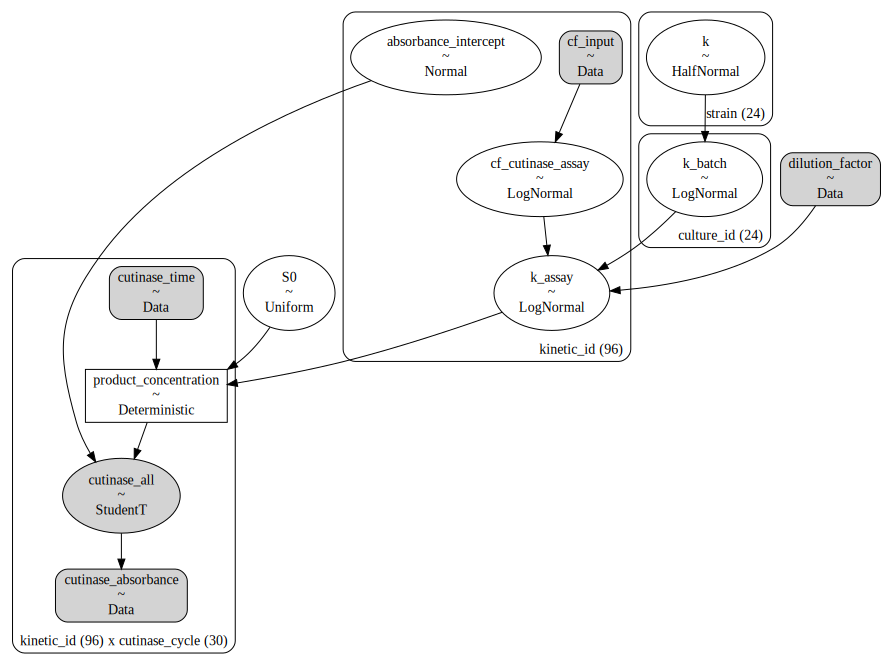

In [18]:
pymc3.model_to_graphviz(model.pmodel)

In [19]:
with model.pmodel:
    idata = pymc3.sample(return_inferencedata=True, target_accept=0.9, tune=100,draws=100)
idata

Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [cf_cutinase_assay, k, k_batch, k_assay, S0, absorbance_intercept]


Sampling 4 chains for 100 tune and 100 draw iterations (400 + 400 draws total) took 60 seconds.


0, dim: kinetic_id, 96 =? 96
1, dim: cutinase_cycle, 30 =? 30


The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The number of effective samples is smaller than 10% for some parameters.


Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data
	> constant_data

The result should be saved such that the analysis can run in another notebook.

In [42]:
idata.to_netcdf(fr"{resultpath}\{RUN_ID}_result_hierarchical.nc")

ValueError: invalid literal for int() with base 10: 'BZACW9_1_B01'

Execute the next cell in case you want to reload saved data

In [18]:
idata = arviz.from_netcdf(fr"{resultpath}\{RUN_ID}_result_exponential.nc")
idata

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data
	> constant_data

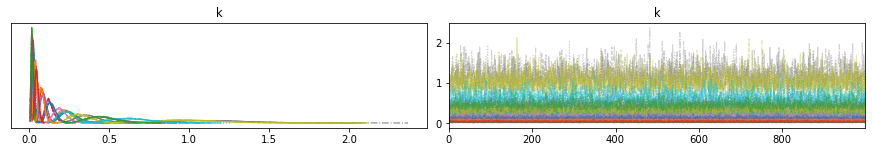

In [19]:
# For every "type" there is a vmax and fmax result:
arviz.plot_trace(idata, var_names=["k"]);
# The left subplots show the posterior probability density.
# The right subplots show the MCMC. If they look like random noise everything is fine.
# The linestyle corresponds to independent MCMC chains - they should come to the same result.

In [29]:
# local vars to make code more readable:
posterior = idata.posterior.stack(sample=("chain", "draw"))
posterior

<xarray.Dataset>
Dimensions:                (kinetic_id: 192, sample: 4000, strain: 24, culture_id: 48, cutinase_cycle: 30)
Coordinates:
  * kinetic_id             (kinetic_id) <U12 'BZACW9_1_B01' ... 'BZP1XQ_2_G12'
  * strain                 (strain) <U4 'AbnA' 'AmyE' 'AprE' ... 'YwaD' 'YwmC'
  * culture_id             (culture_id) <U10 'BZACW9_A02' ... 'BZP1XQ_F07'
  * cutinase_cycle         (cutinase_cycle) int32 0 1 2 3 4 5 ... 25 26 27 28 29
  * sample                 (sample) MultiIndex
  - chain                  (sample) int64 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3
  - draw                   (sample) int64 0 1 2 3 4 5 ... 995 996 997 998 999
Data variables:
    cf_cutinase_assay      (kinetic_id, sample) float64 0.4788 0.7498 ... 1.6
    k                      (strain, sample) float64 0.2242 0.141 ... 0.05905
    k_batch                (culture_id, sample) float64 0.06918 ... 0.09159
    k_assay                (kinetic_id, sample) float64 0.0008281 ... 0.001421
    S0                     (sample) float64 0.5644 0.5684 ... 0.6719 0.6717
    absorbance_intercept   (kinetic_id, sample) float64 0.3901 0.3464 ... 0.3731
    product_concentration  (kinetic_id, cutinase_cycle, sample) float64 0.0 ....
Attributes:
    created_at:                 2021-09-15T07:08:32.190057
    arviz_version:              0.11.2
    inference_library:          pymc3
    inference_library_version:  4.0
    sampling_time:              285.586354970932
    tuning_steps:               1000

array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

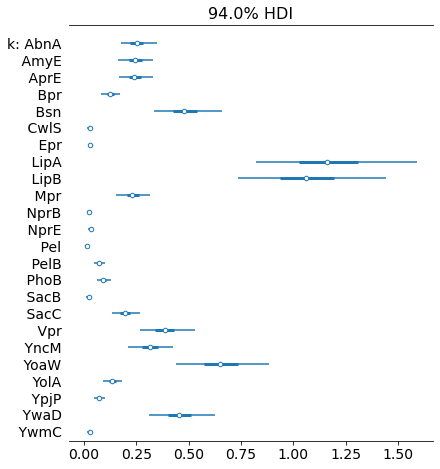

In [48]:
arviz.plot_forest(idata, var_names=["k"], combined=True)

In [22]:
for typ in posterior.type.values:
    print(typ)
    print(posterior.k.sel(type=typ).values.mean())

AbnA
0.25422309114727565
AmyE
0.23230539193206357
AprE
0.24888979504644074
Bpr
0.12742588839990598
Bsn
0.4733089095697616
CwlS
0.039757318603939294
Epr
0.038621460142364596
LipA
1.150211398848646
LipB
1.0055318149050037
Mpr
0.23970582333161894
NprB
0.0274911157429672
NprE
0.03995313375975991
Pel
0.01719154543840773
PelB
0.0823319181197136
PhoB
0.09111837956384188
SacB
0.021984540368907863
SacC
0.1964964788915079
Vpr
0.3762809139015744
YncM
0.32597063067657656
YoaW
0.6461856246344593
YolA
0.13926251921871774
YpjP
0.07833127161031332
YwaD
0.45615877535911387
YwmC
0.04703828263143552


In [13]:
idata

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data
	> constant_data

C:\Users\HELLEC~1\AppData\Local\Temp/ipykernel_16072/451149888.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = pyplot.subplots(


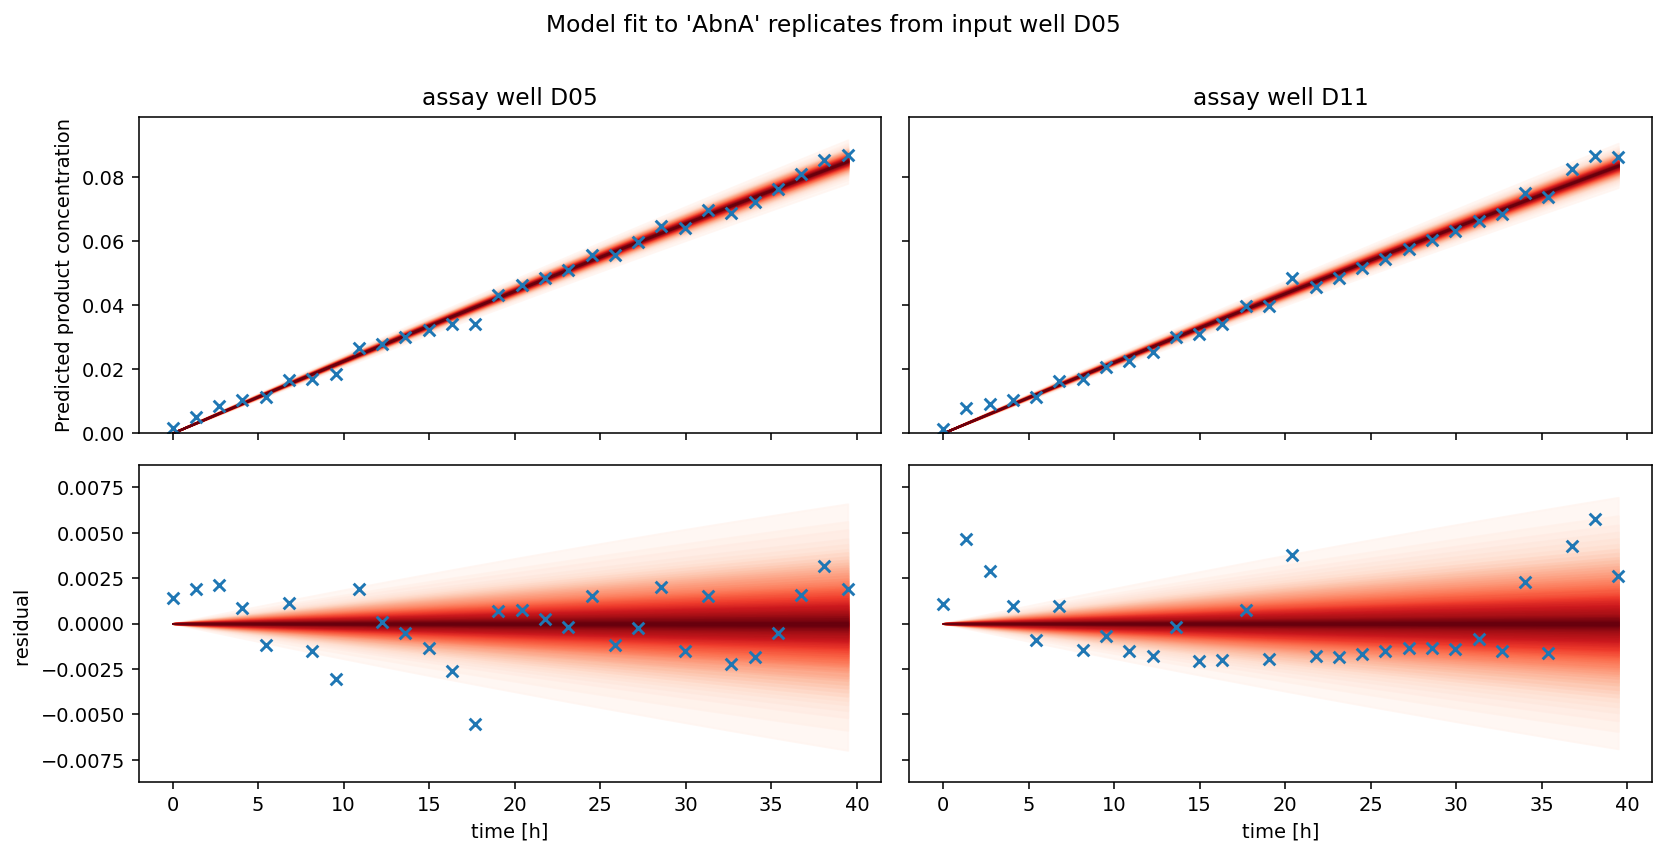

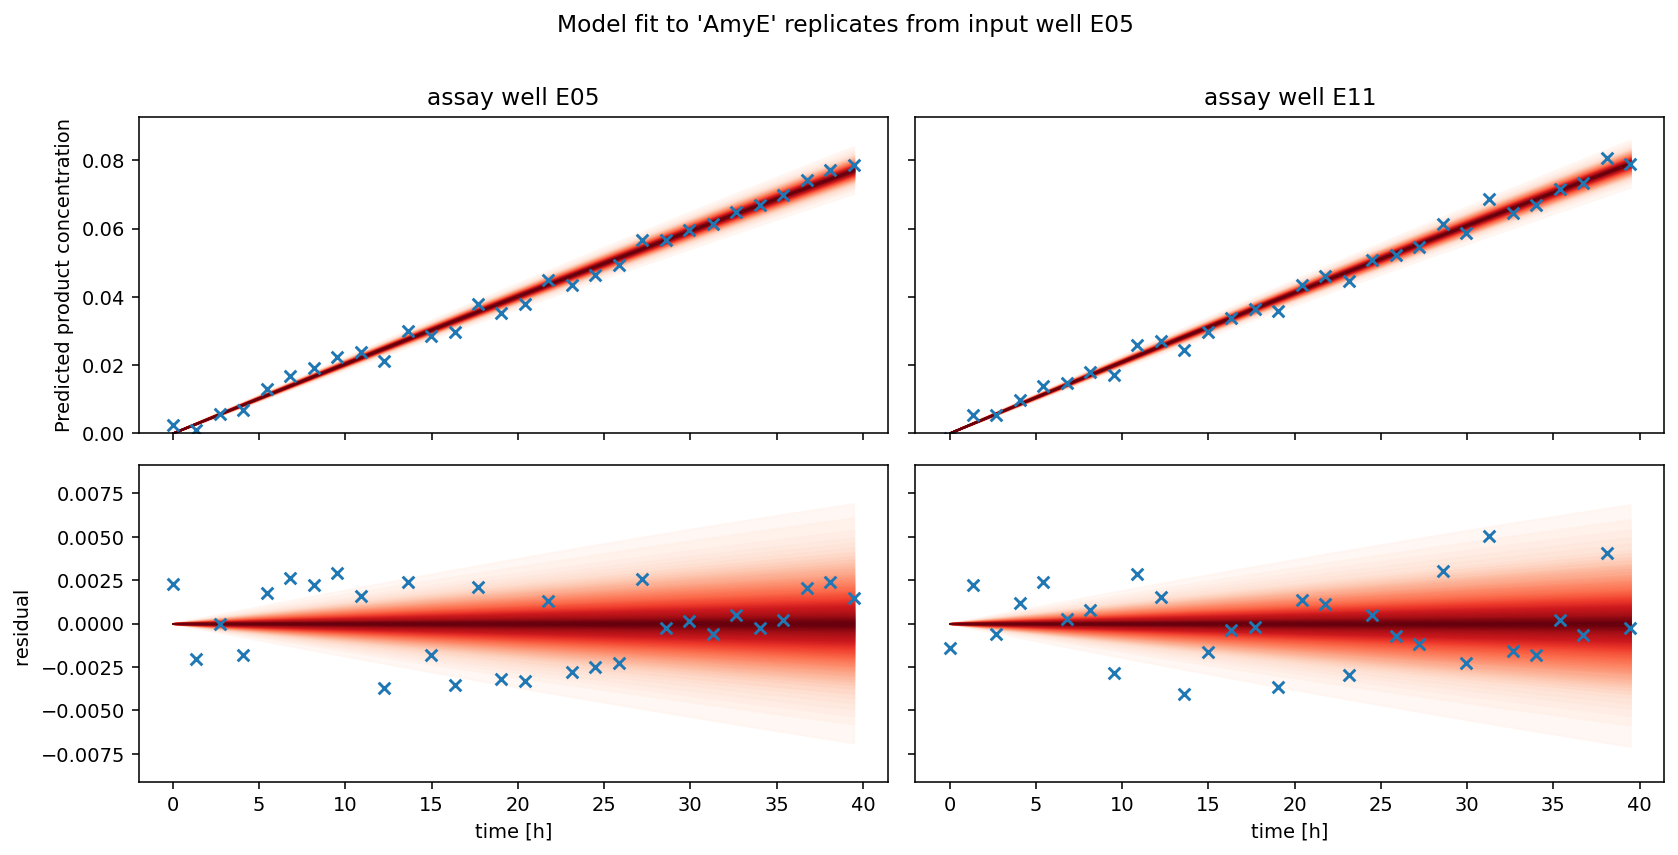

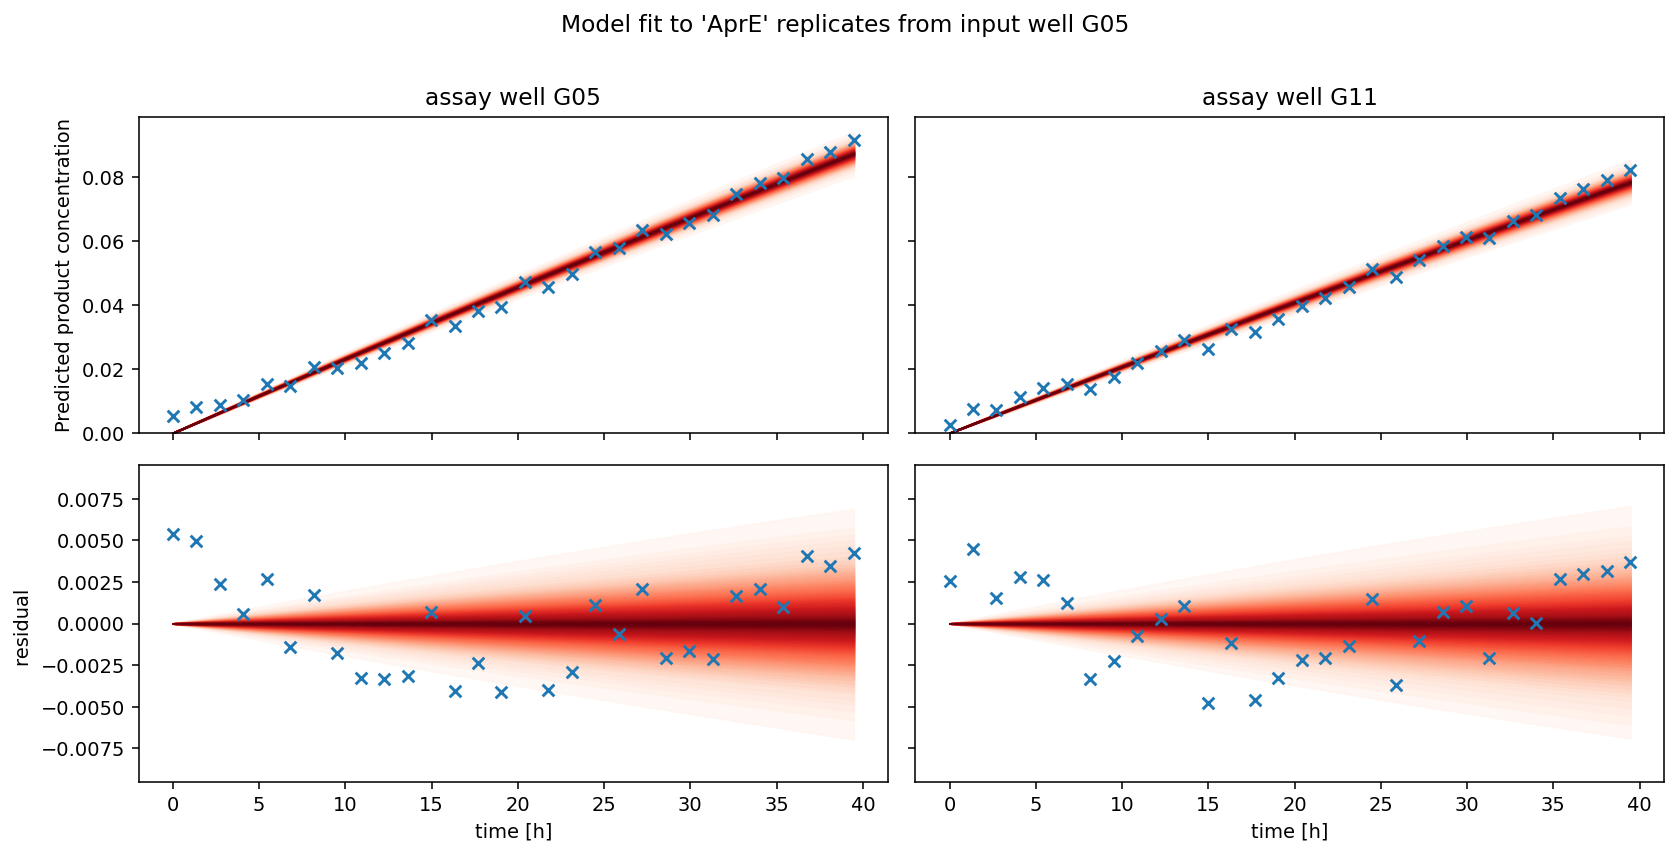

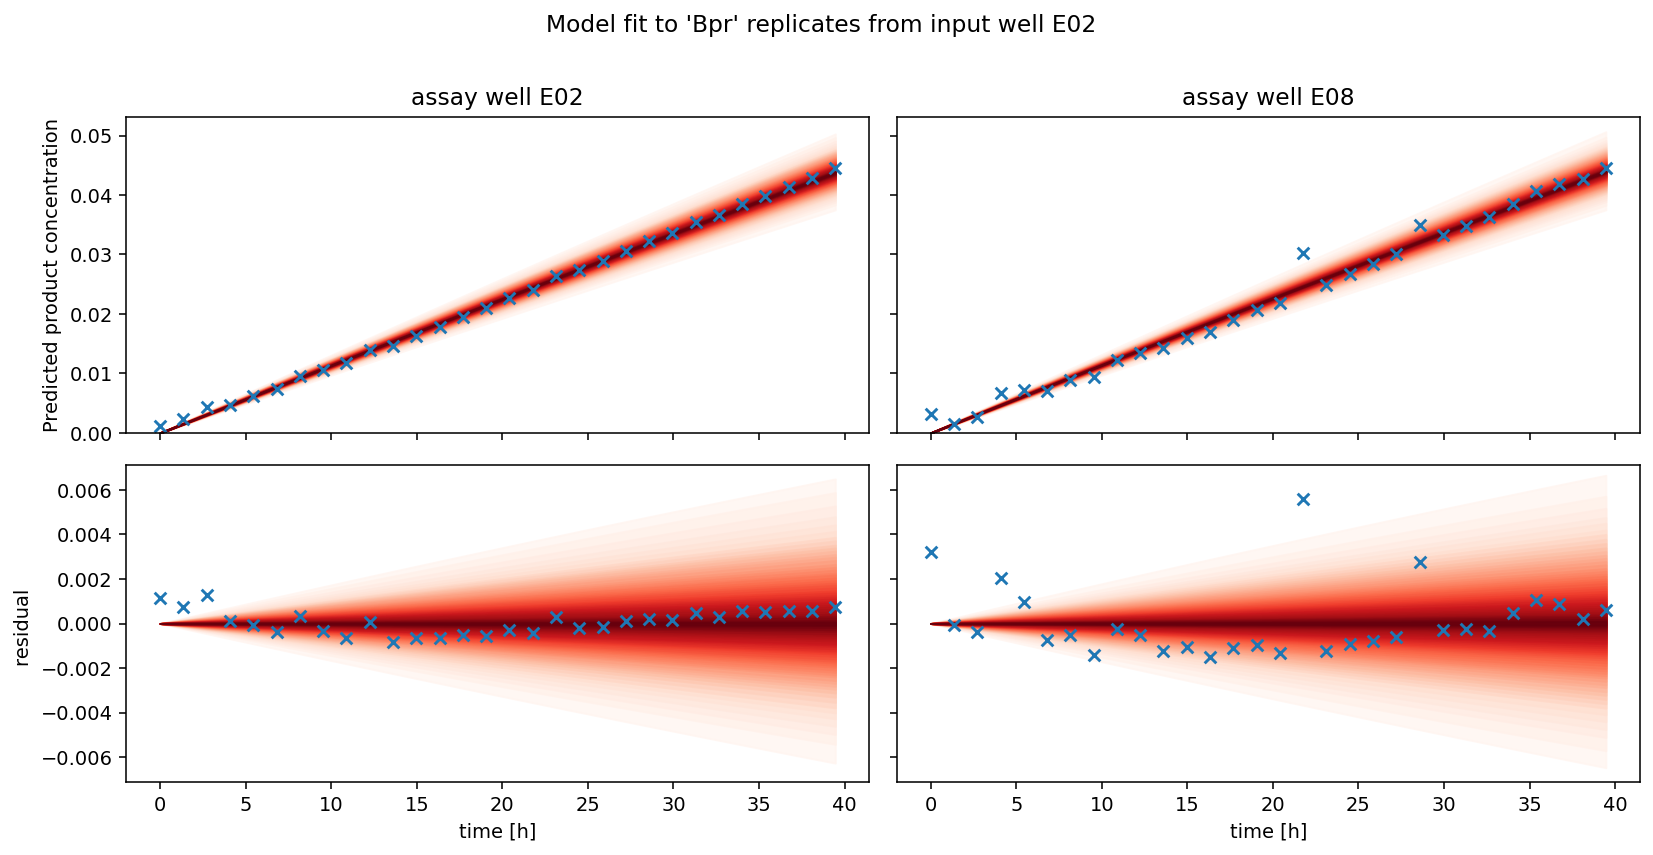

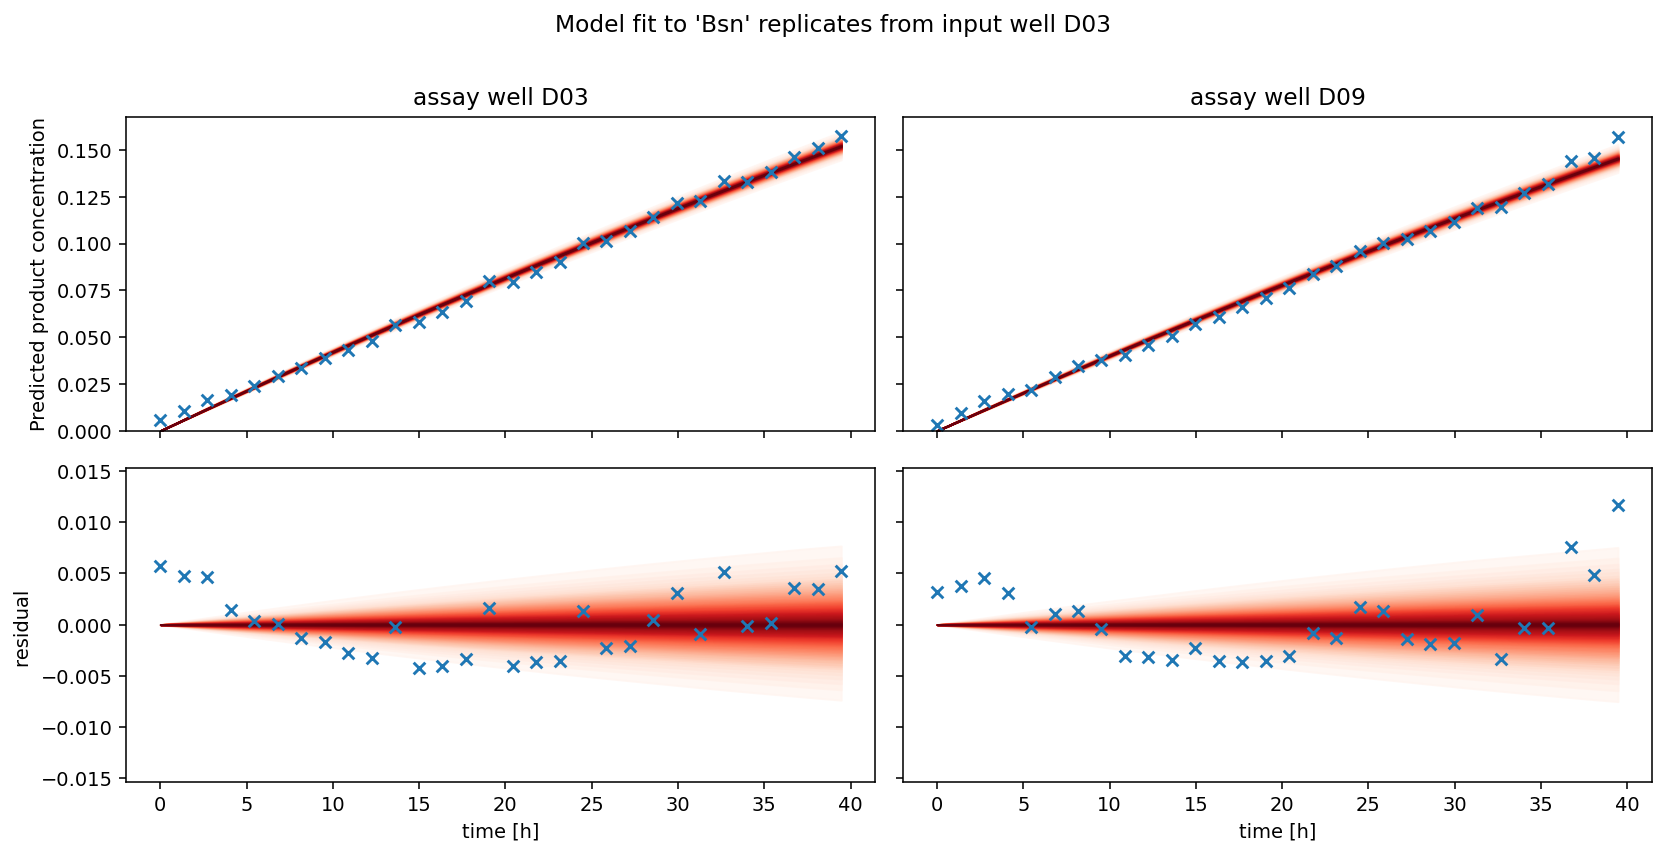

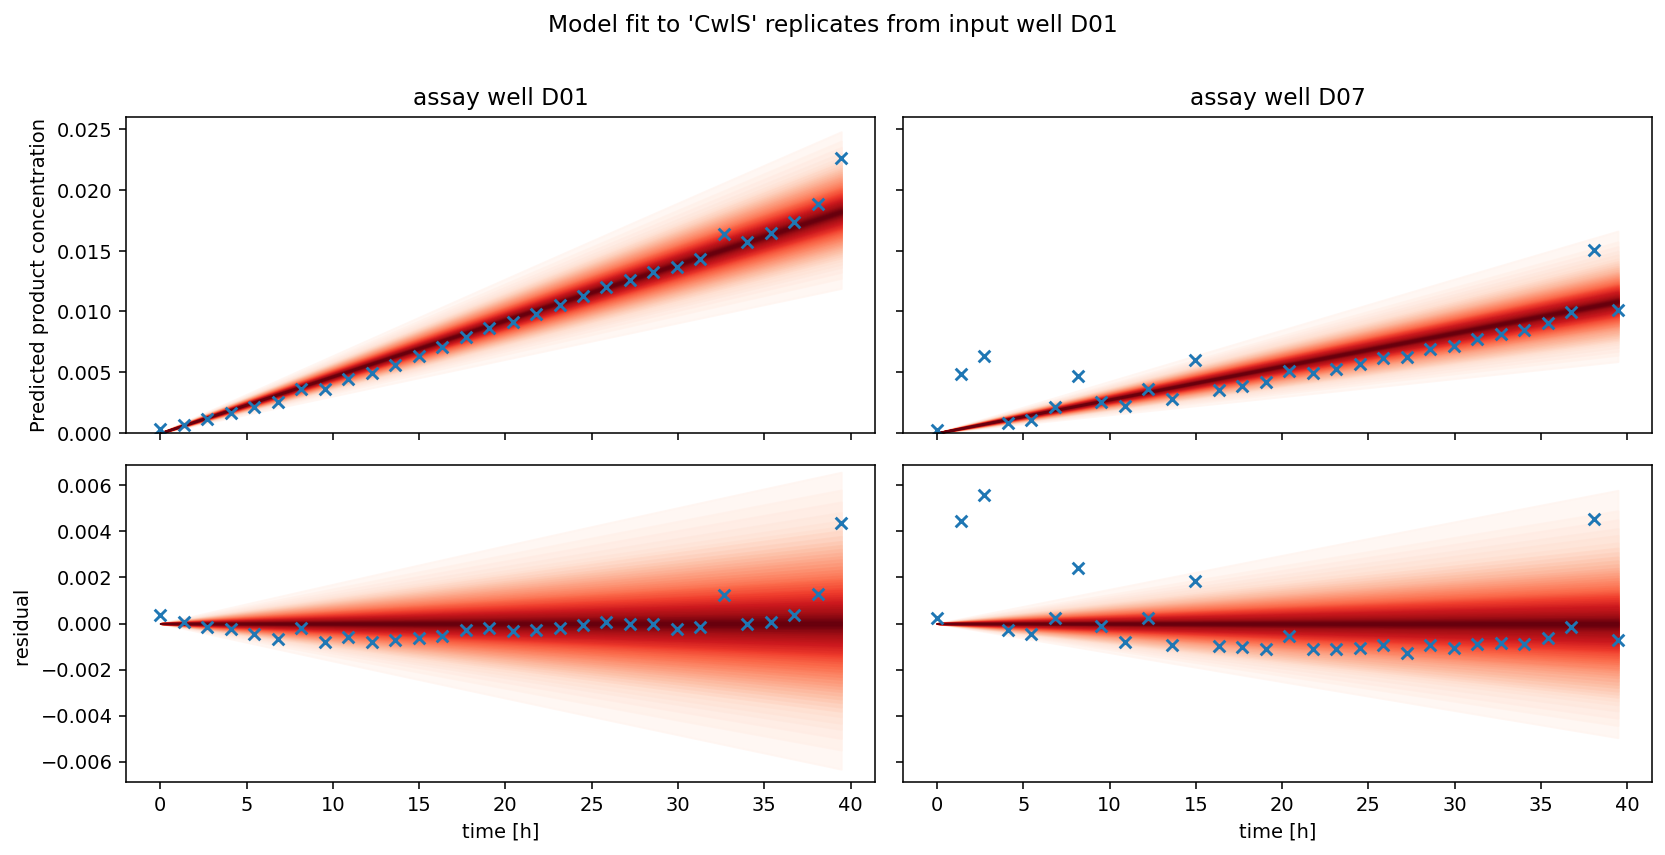

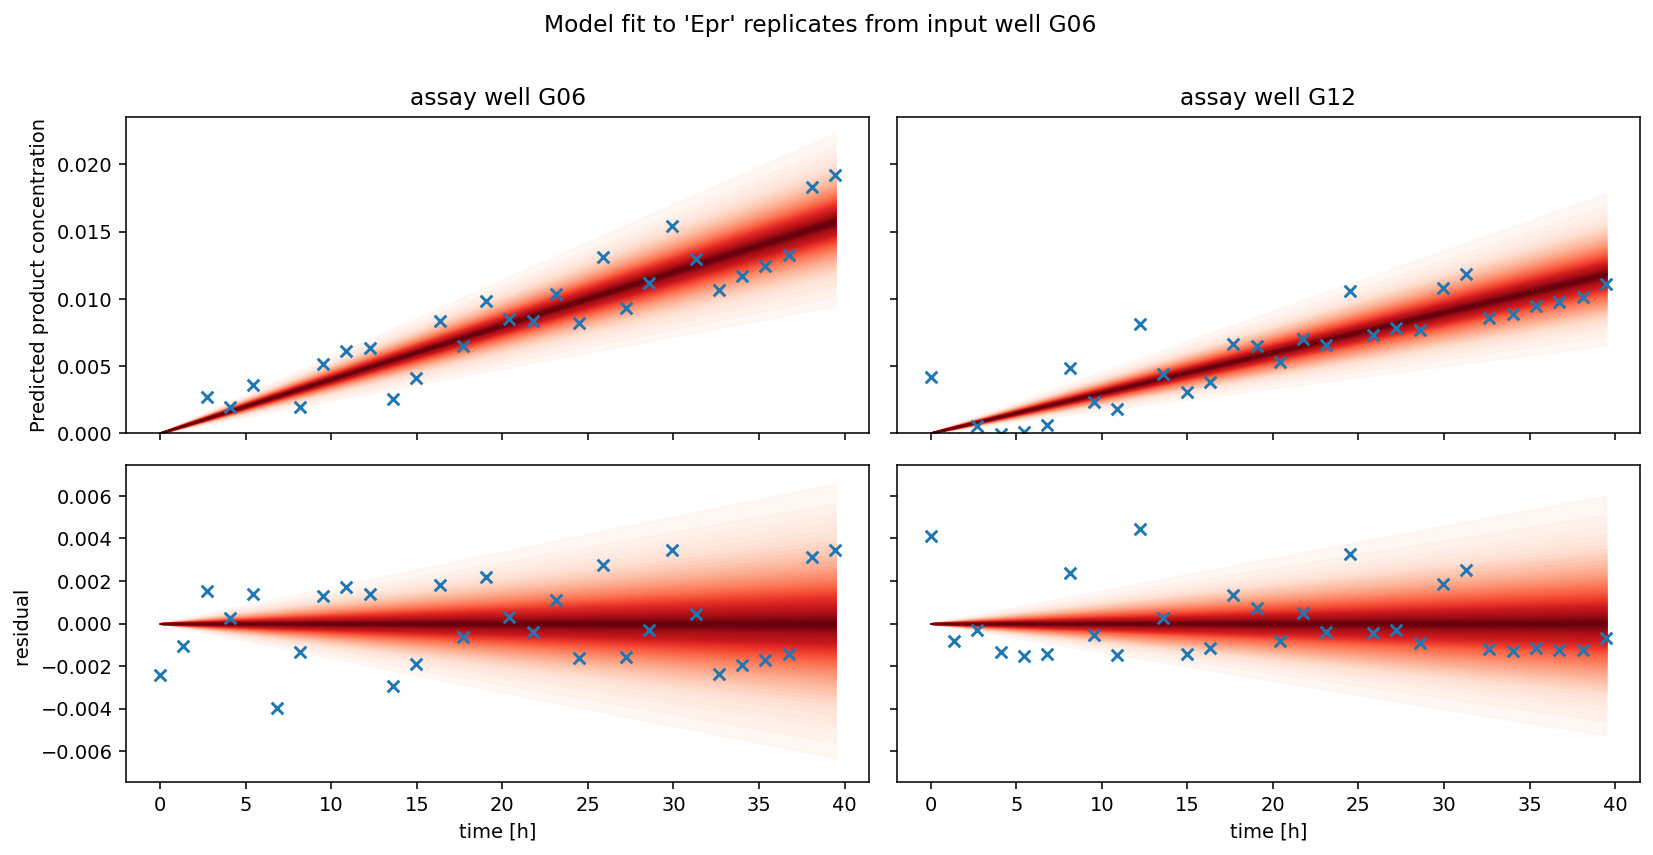

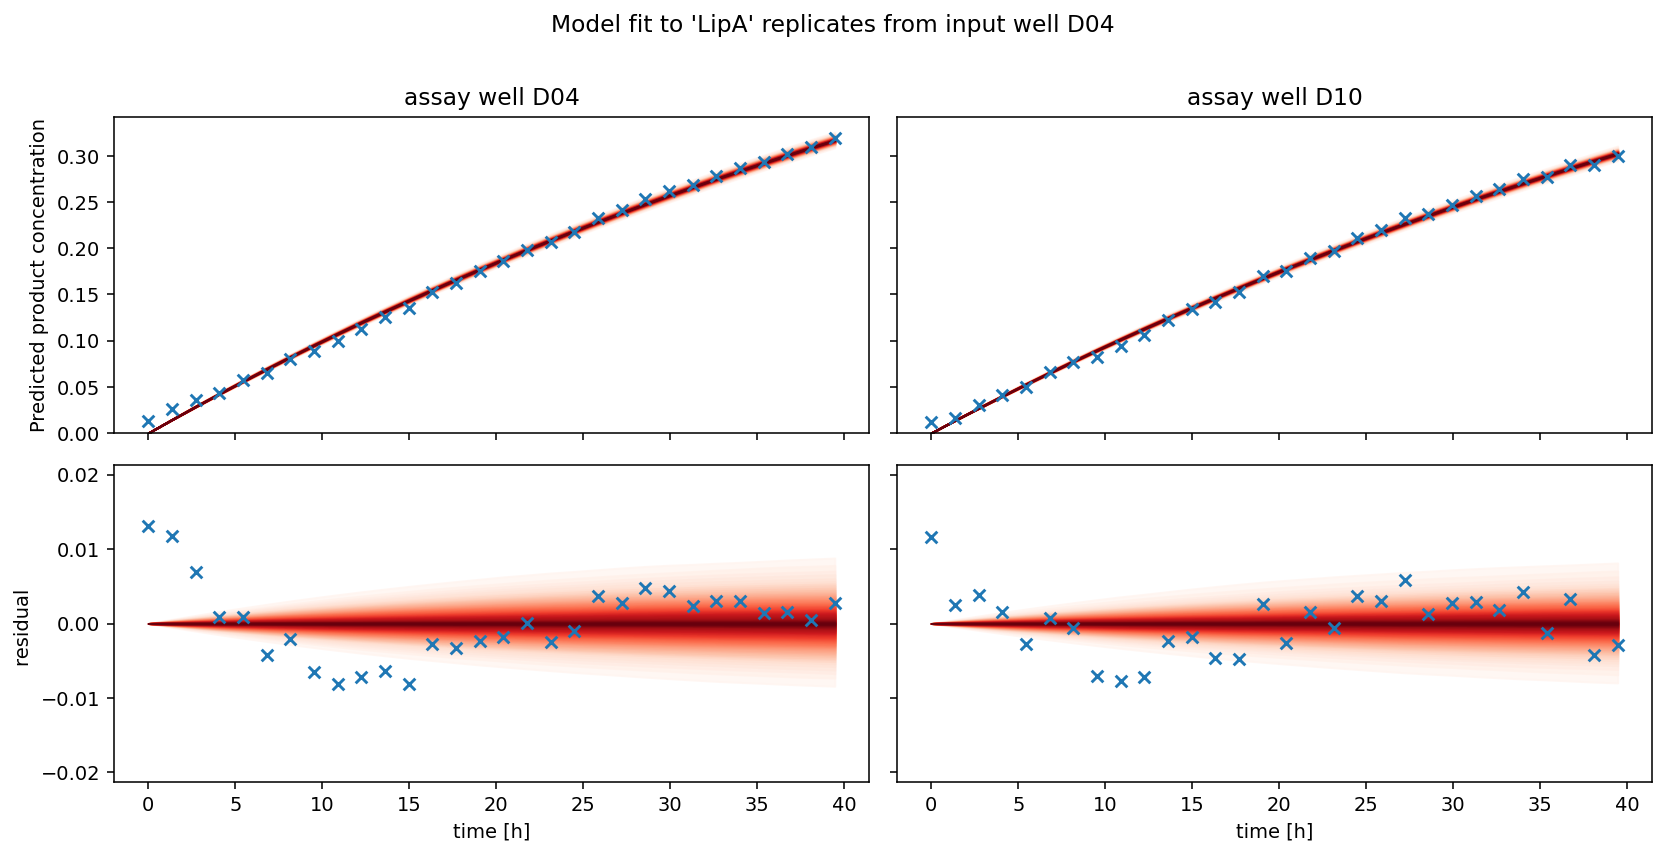

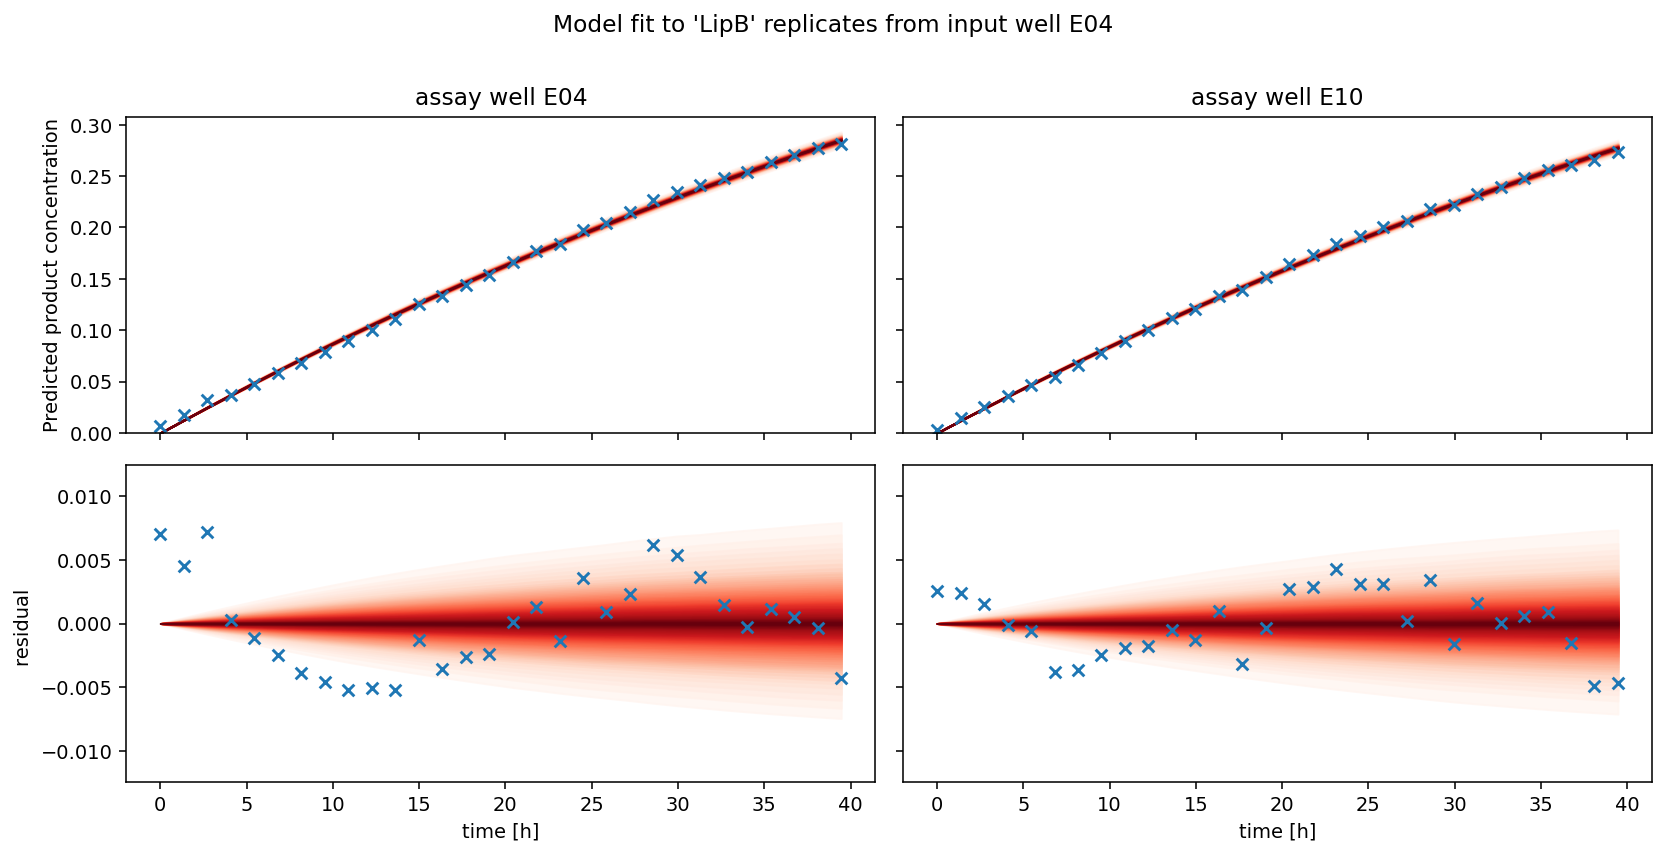

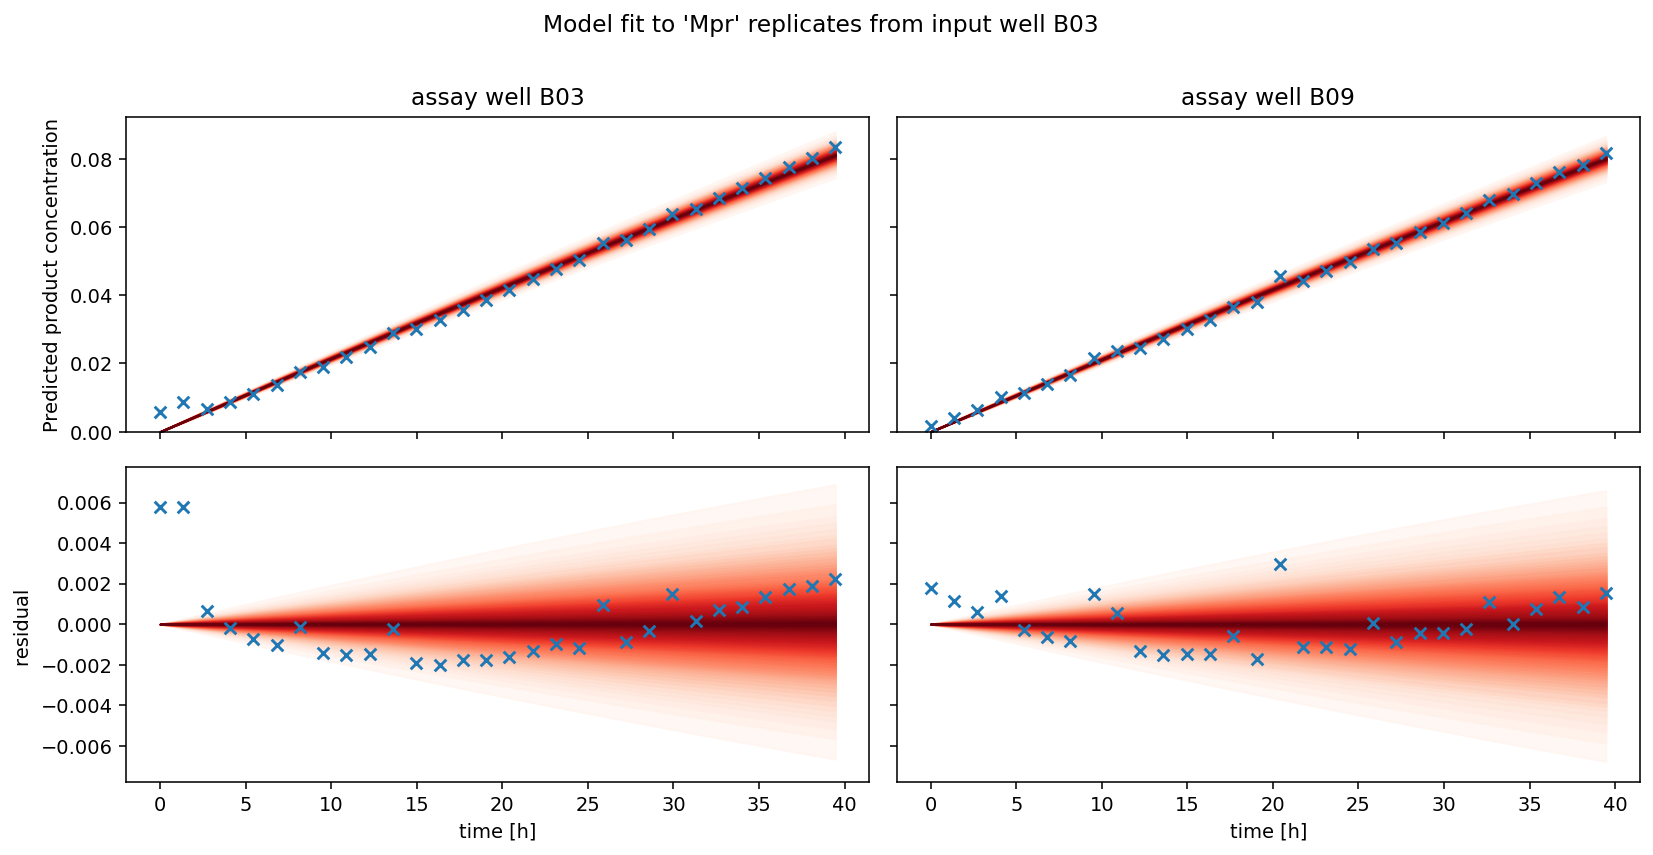

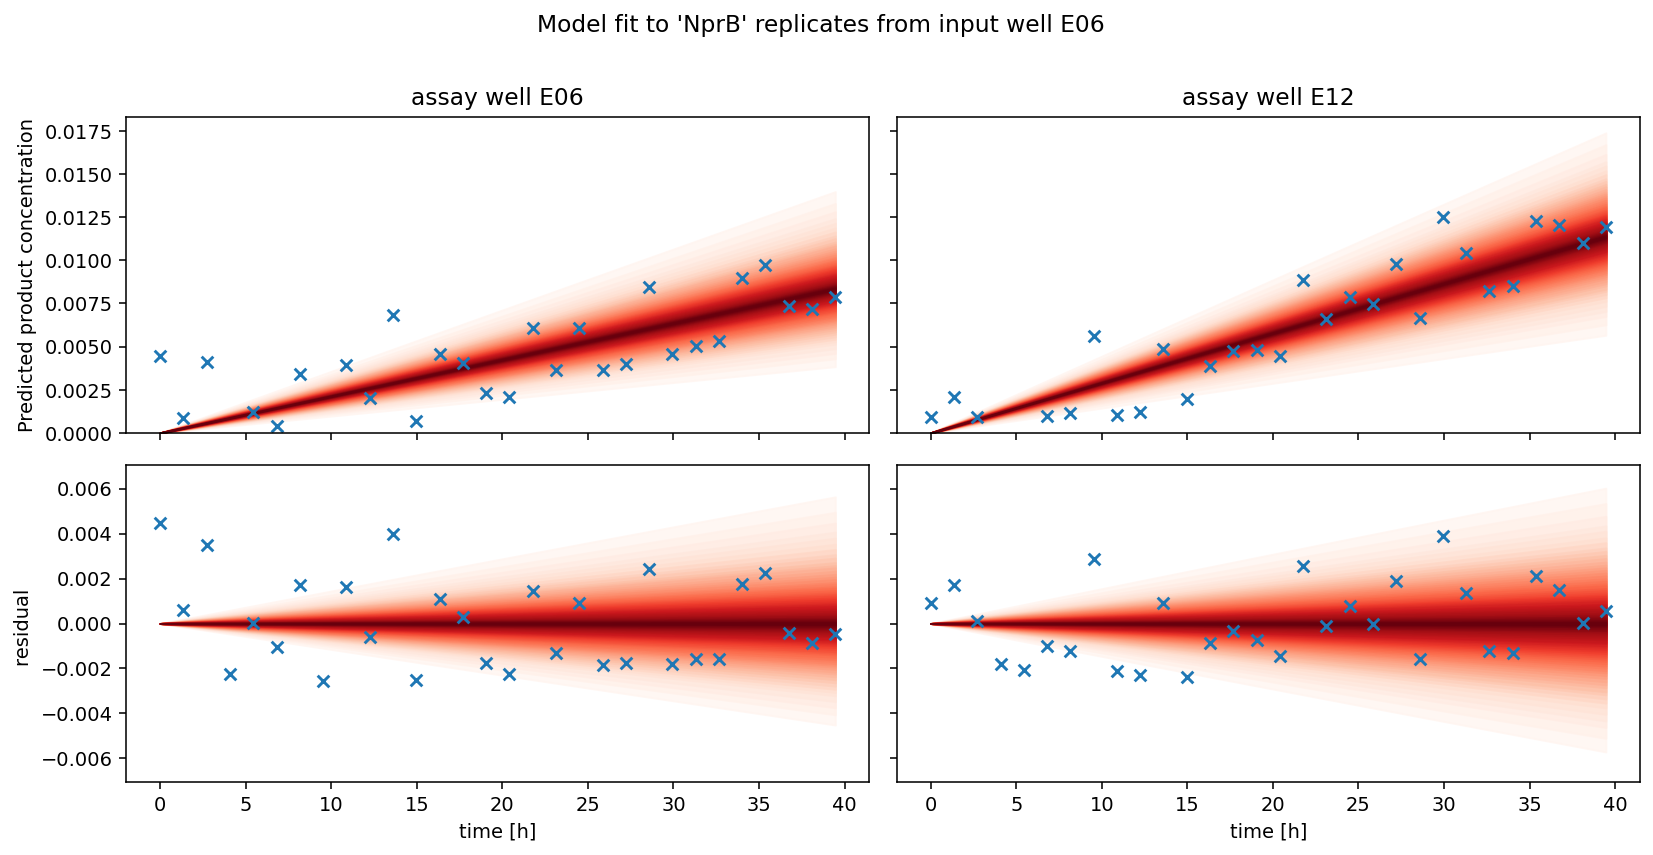

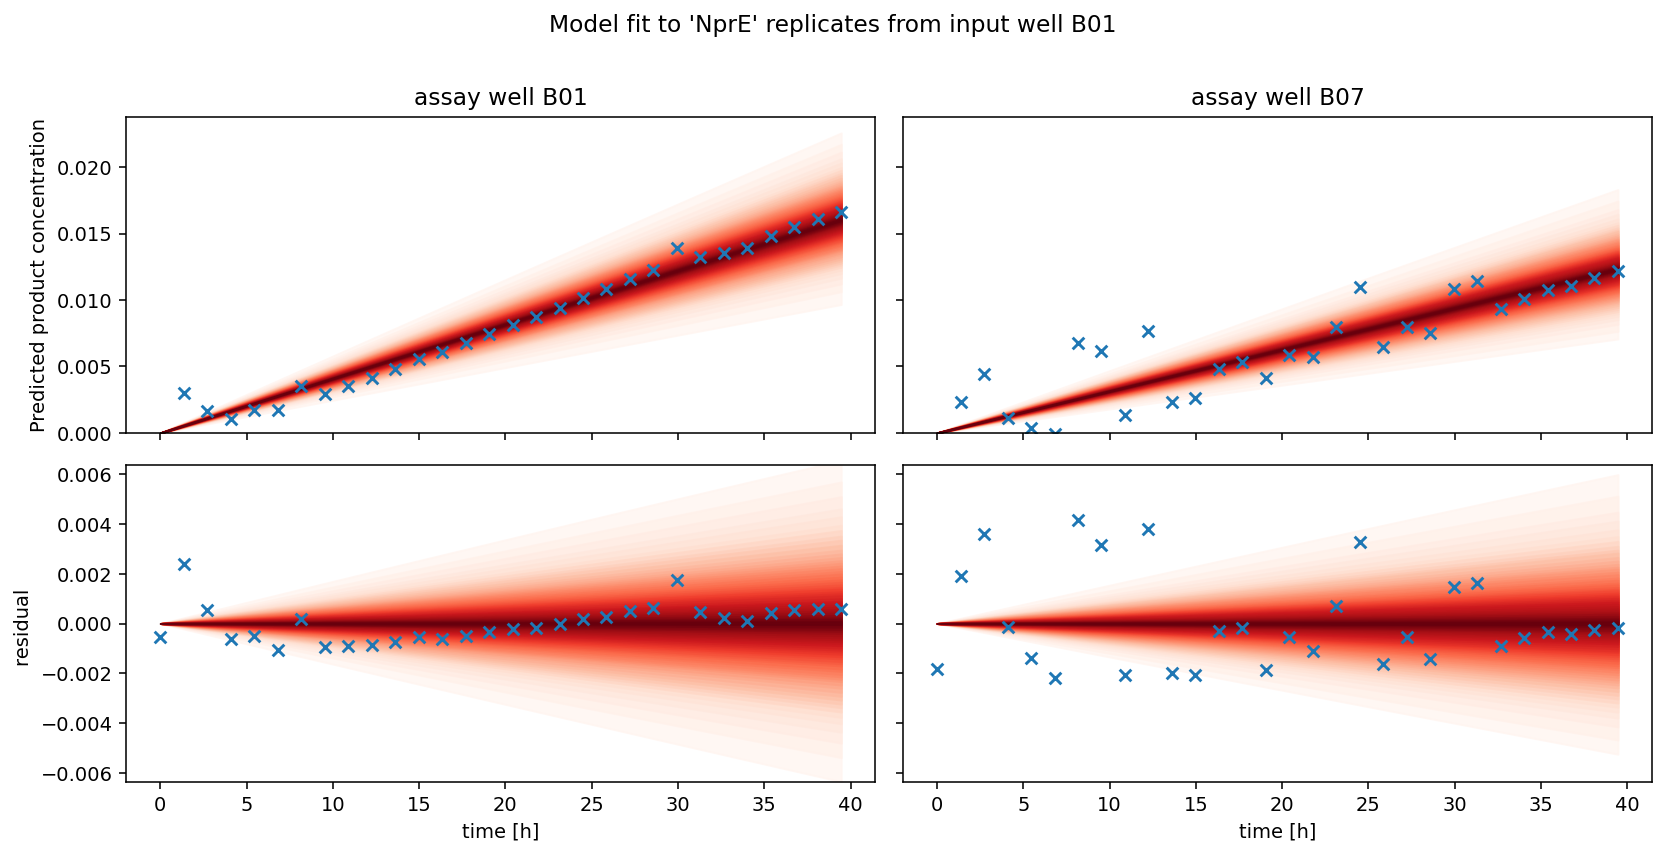

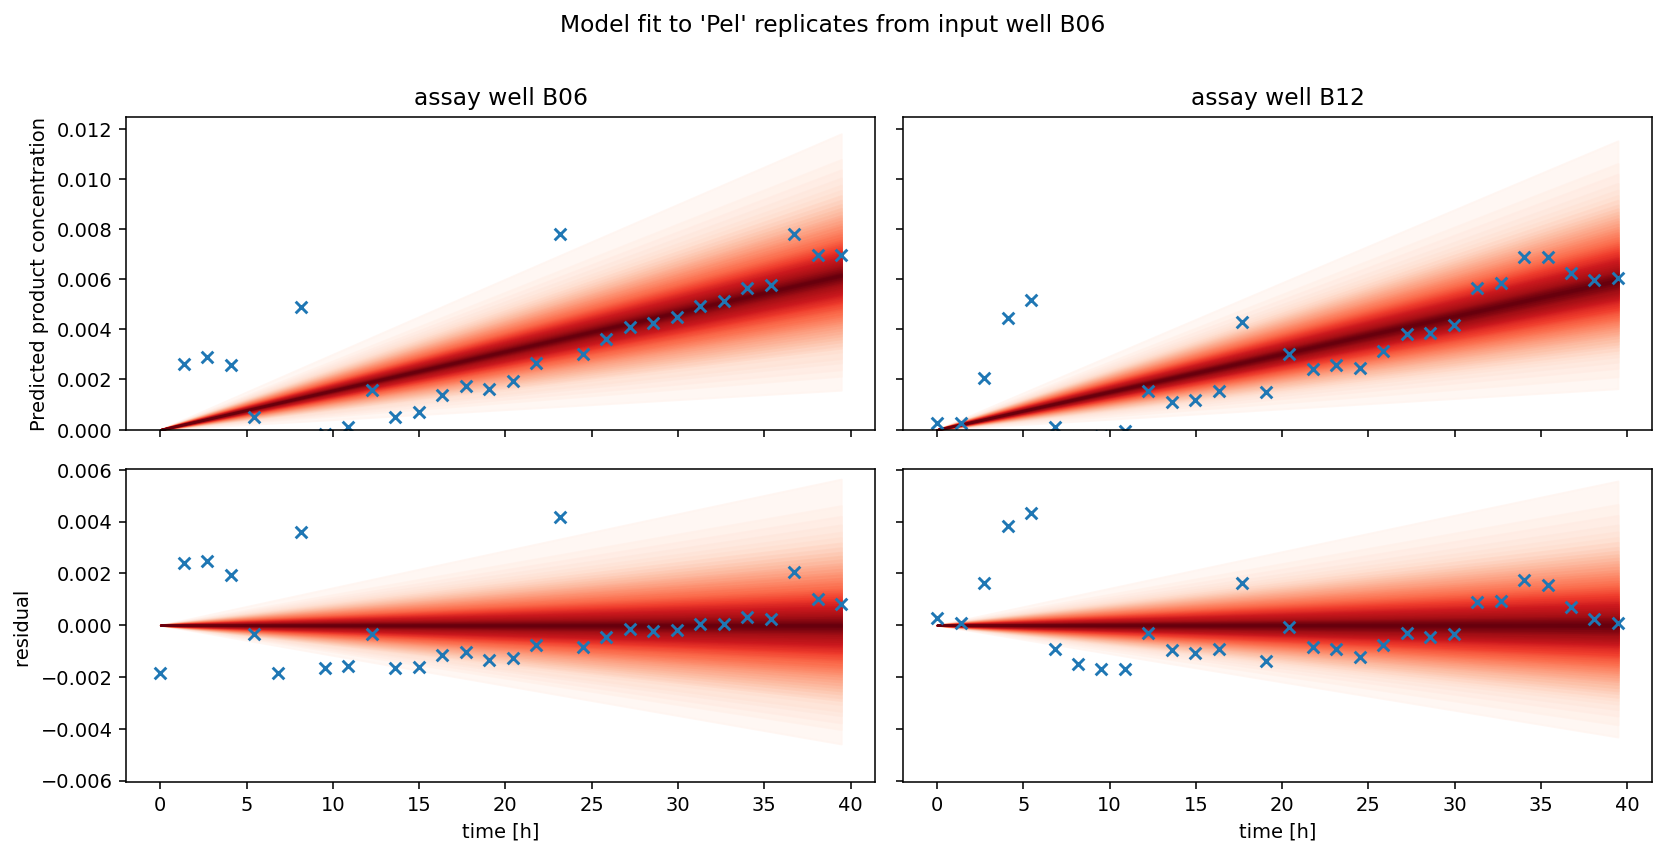

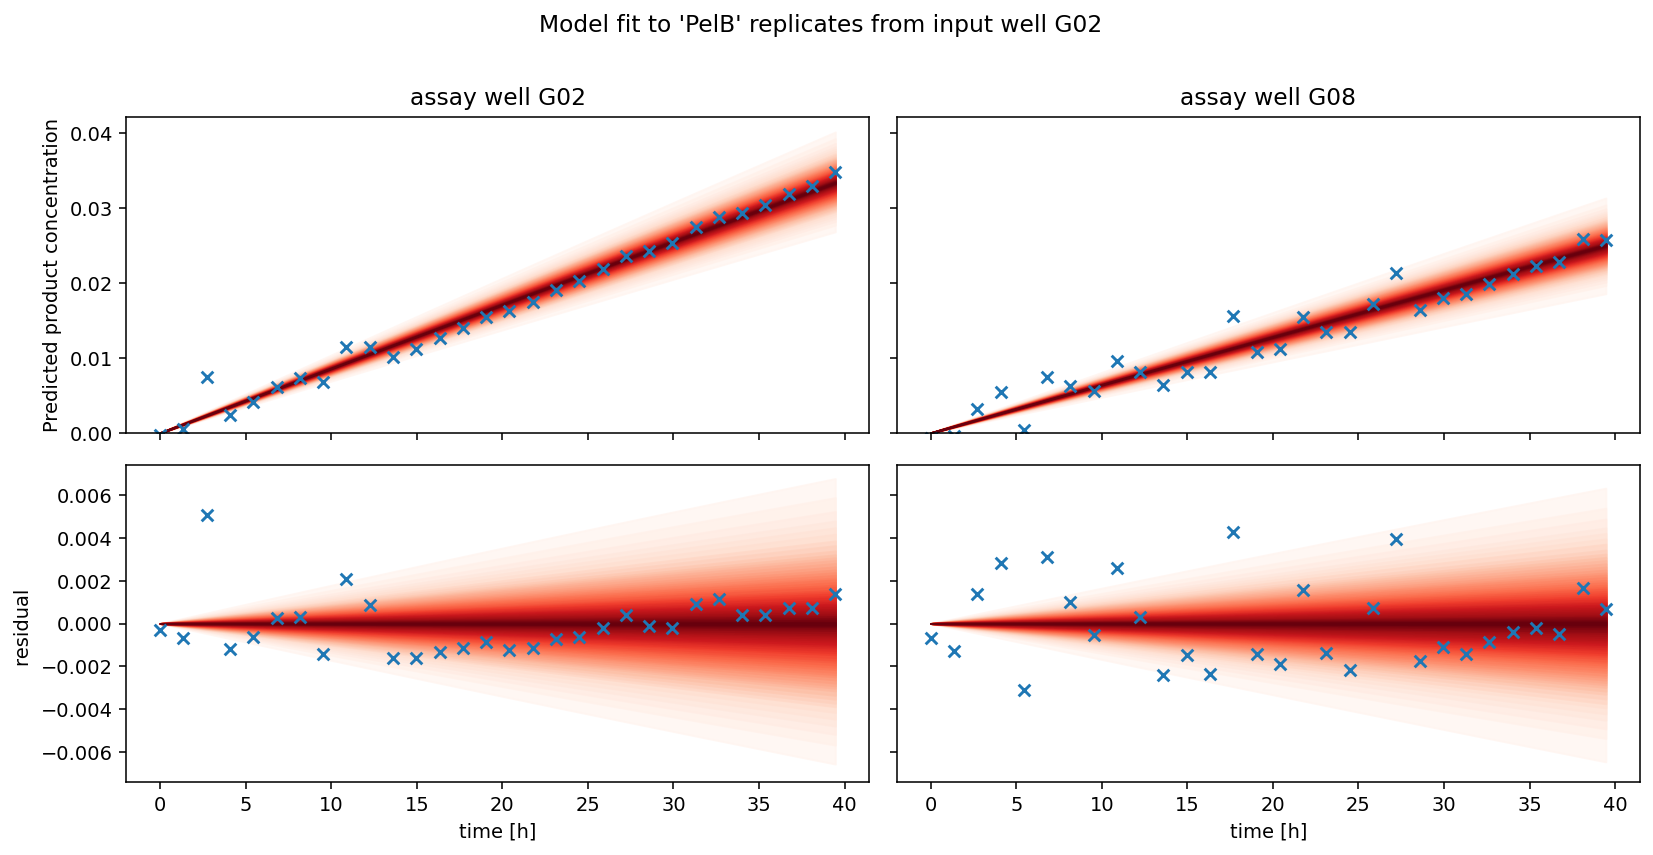

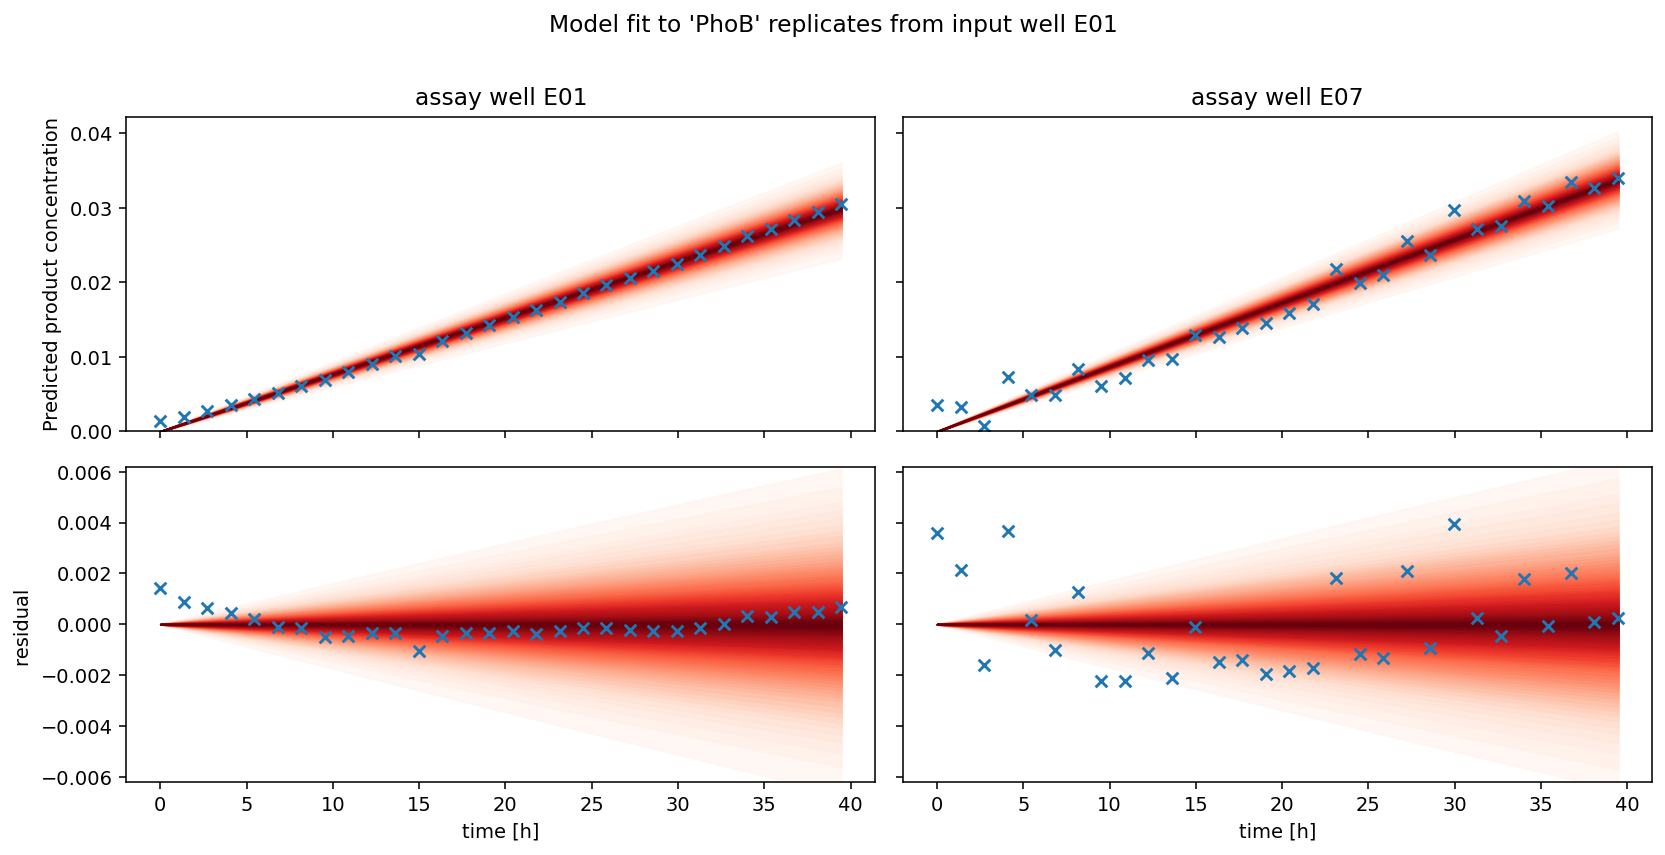

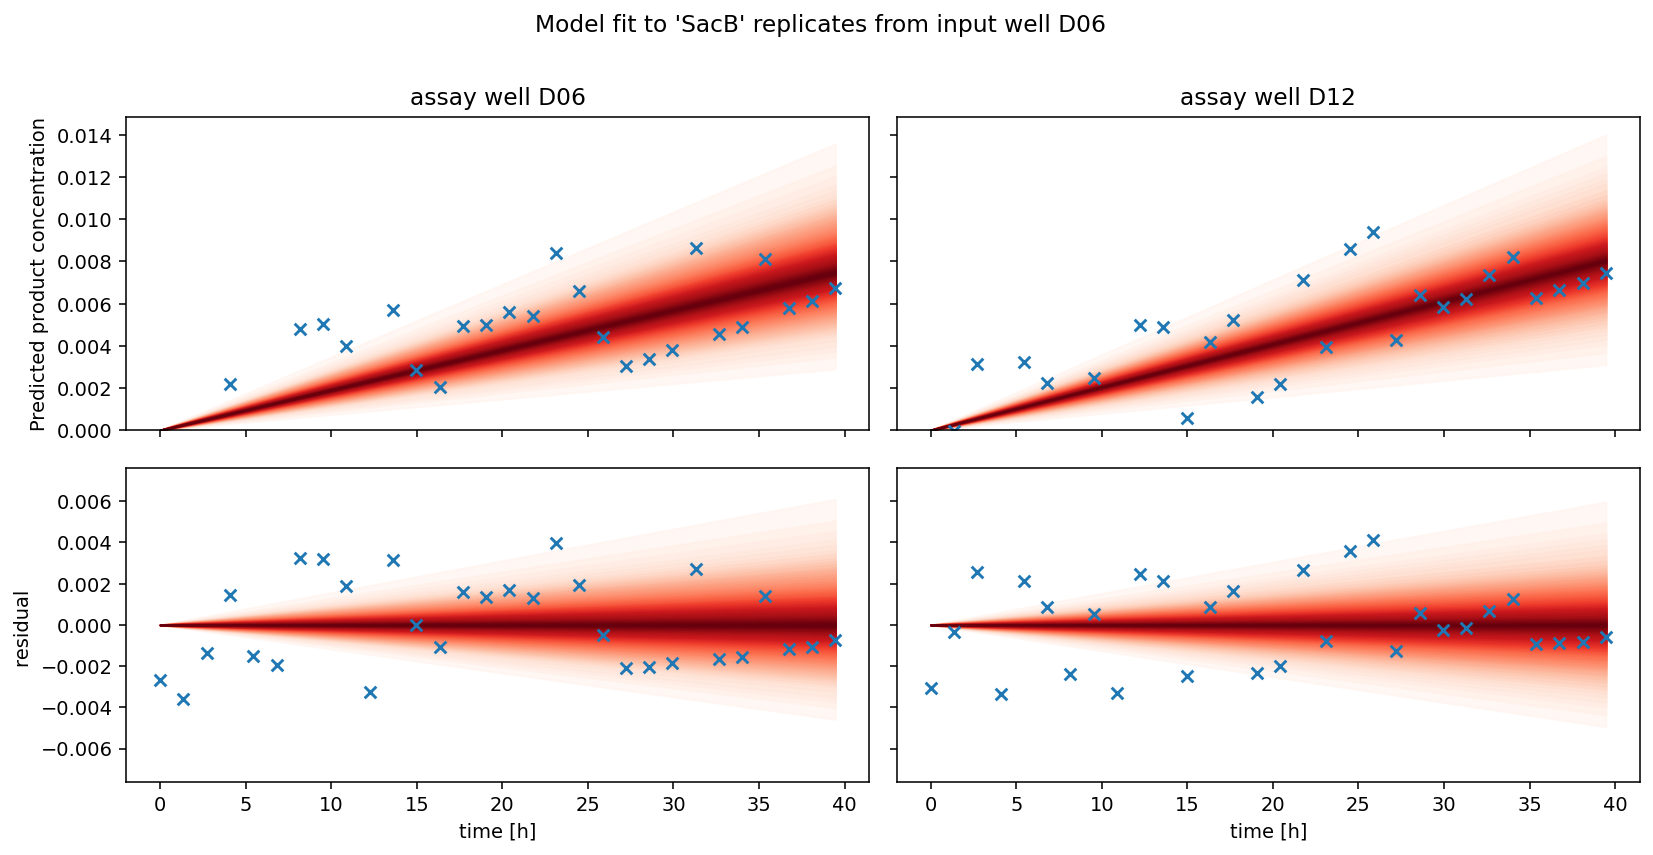

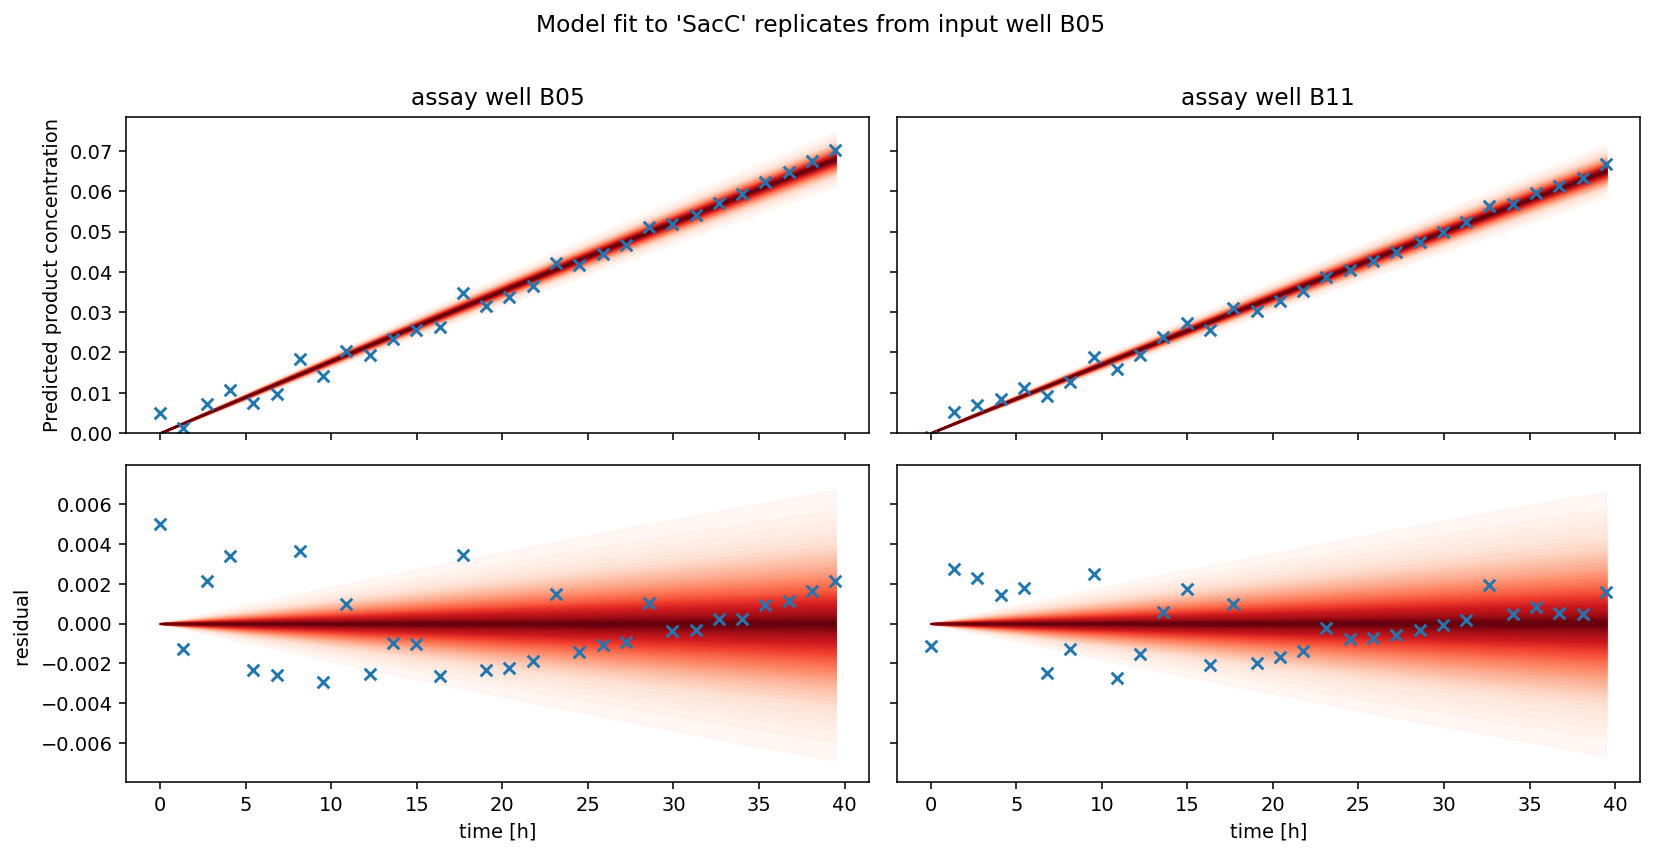

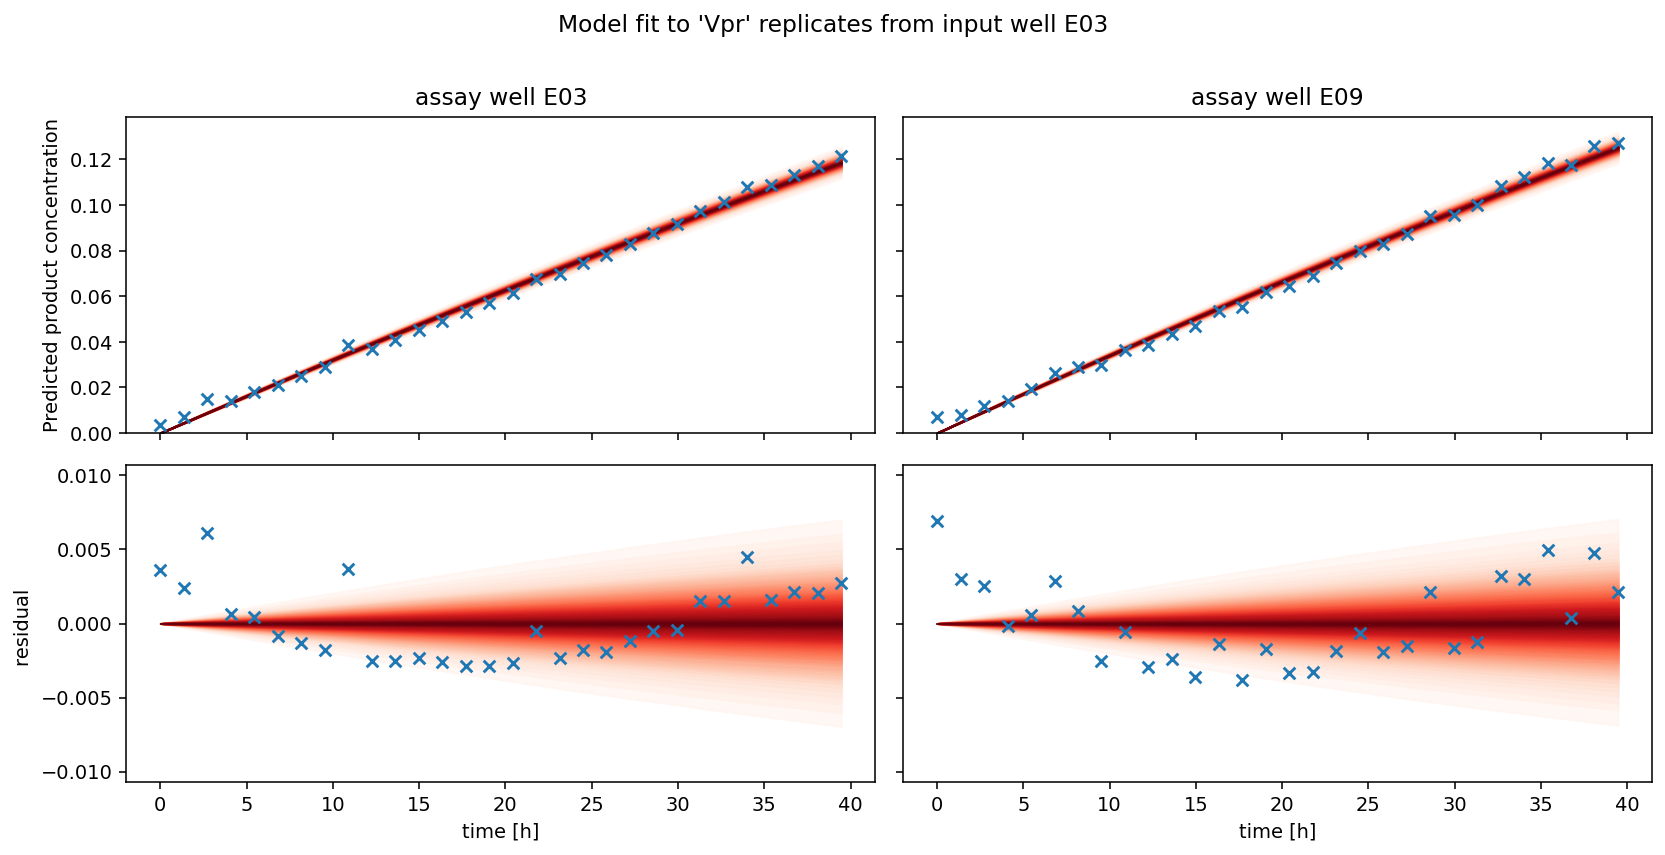

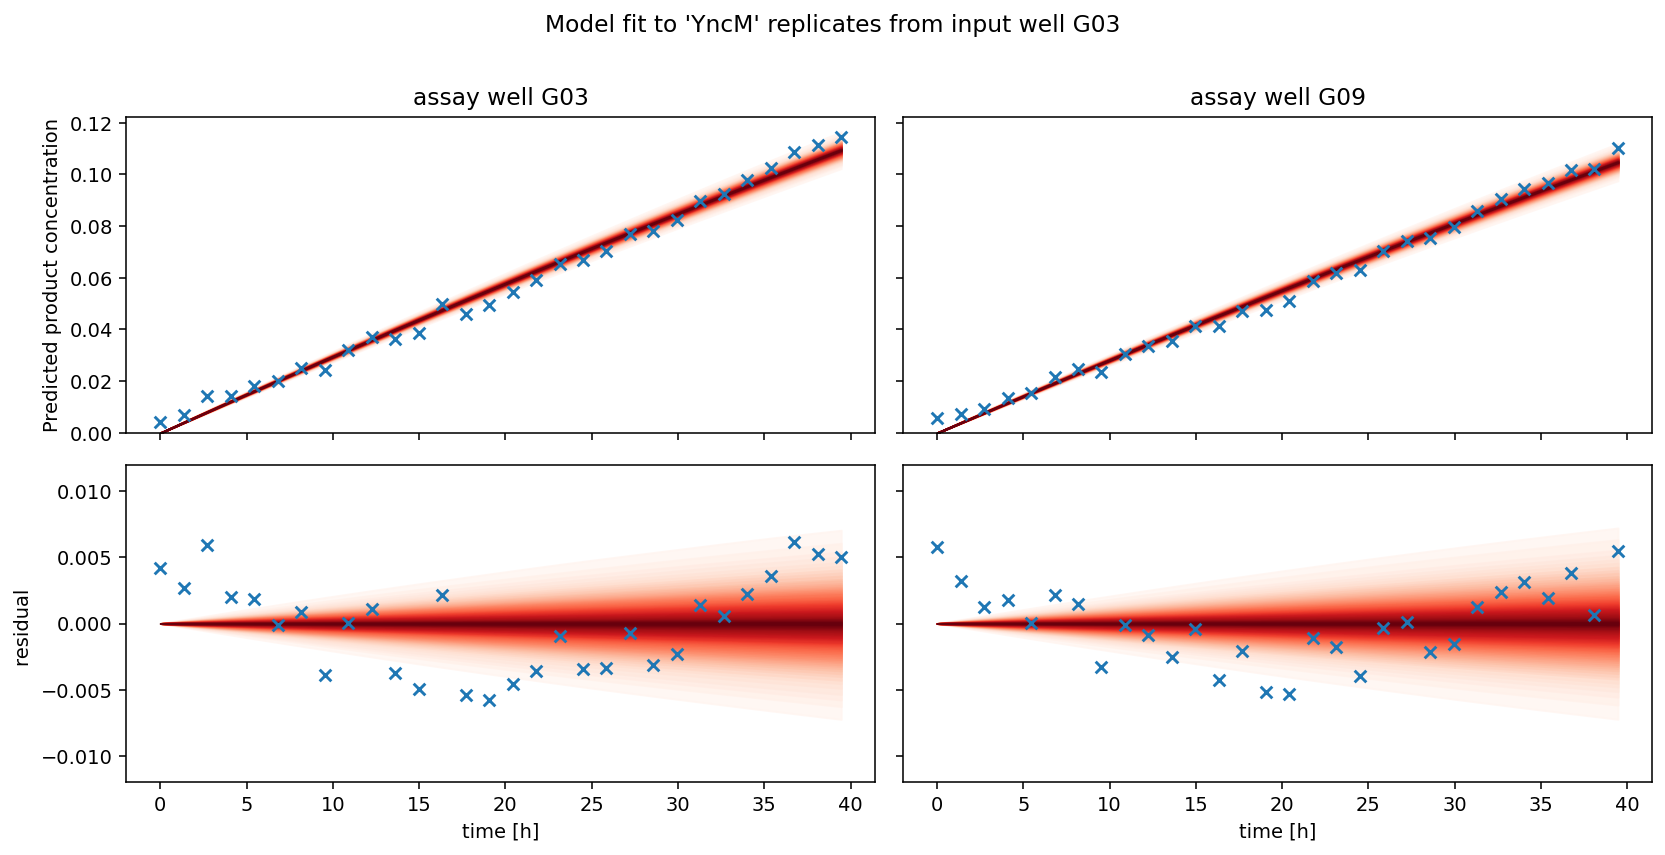

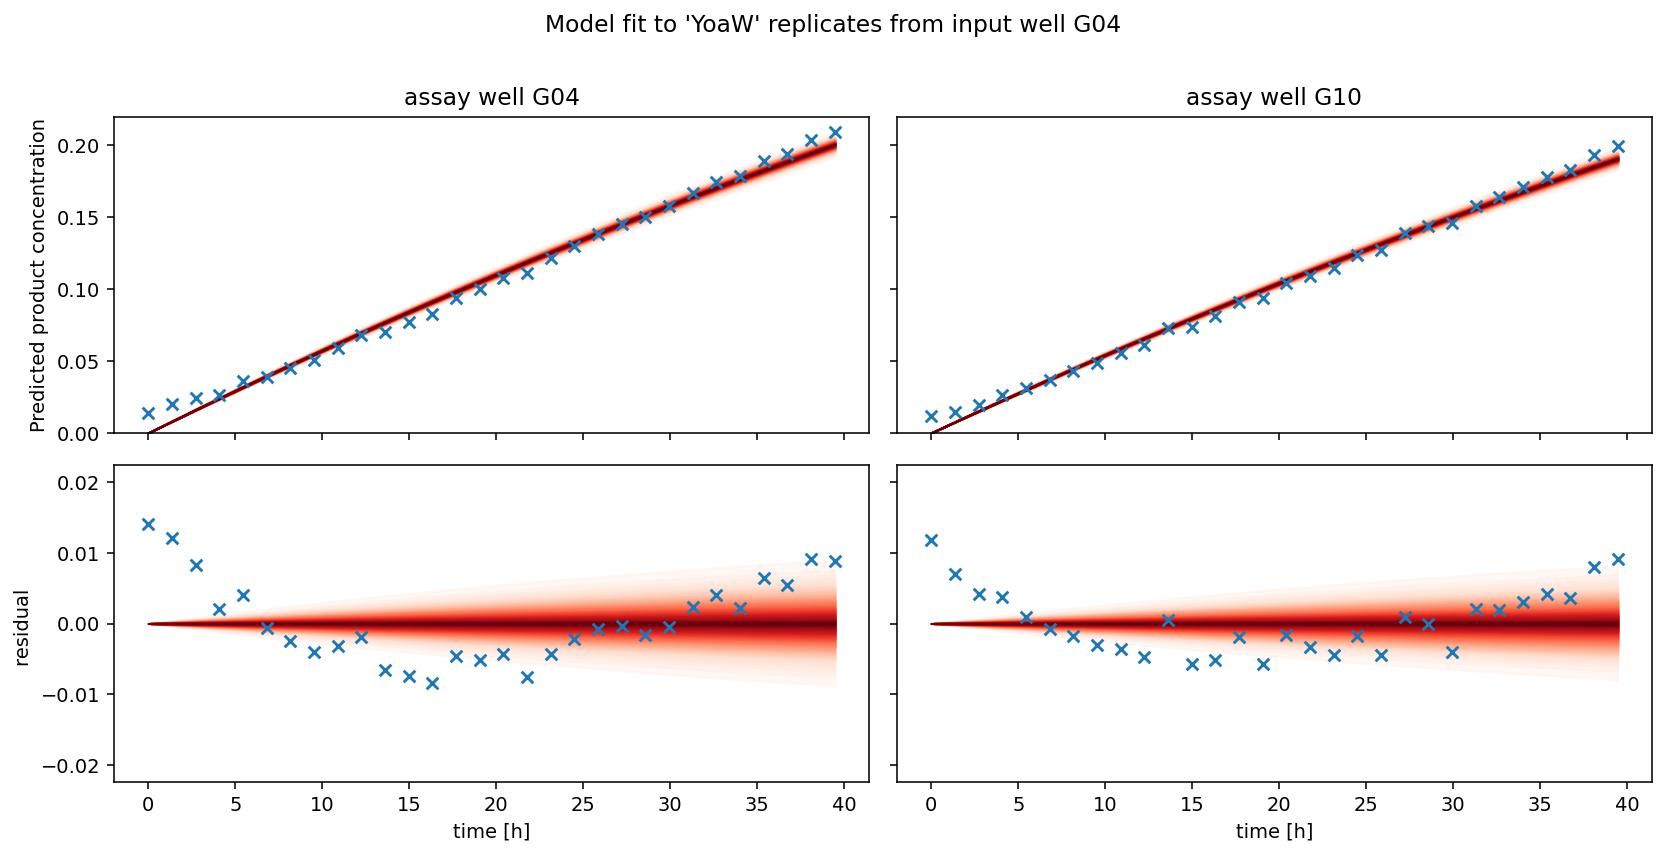

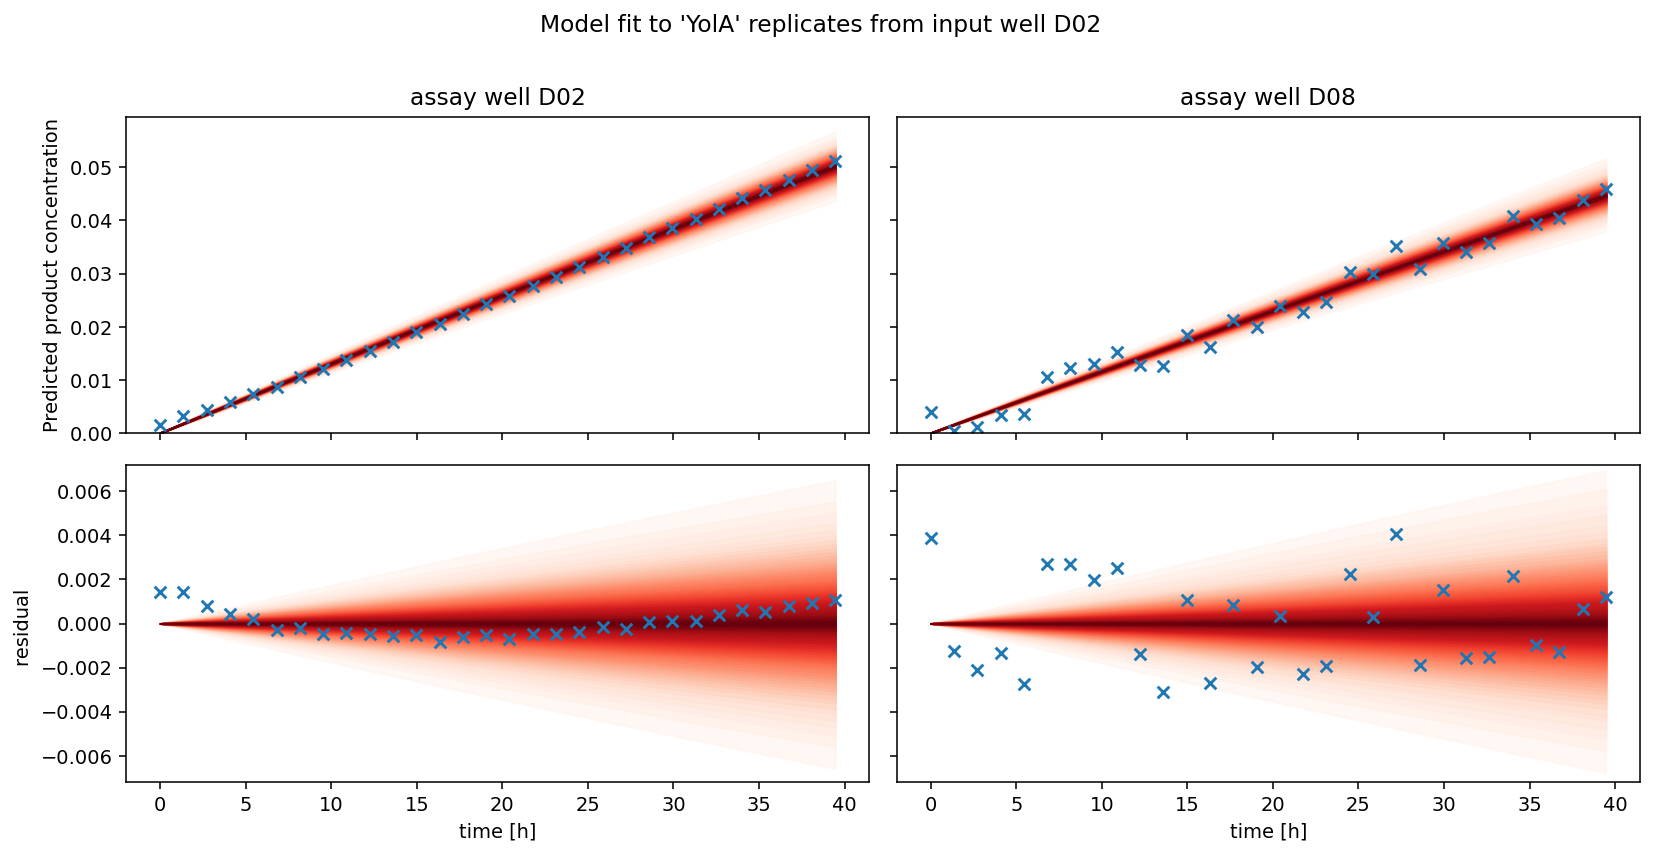

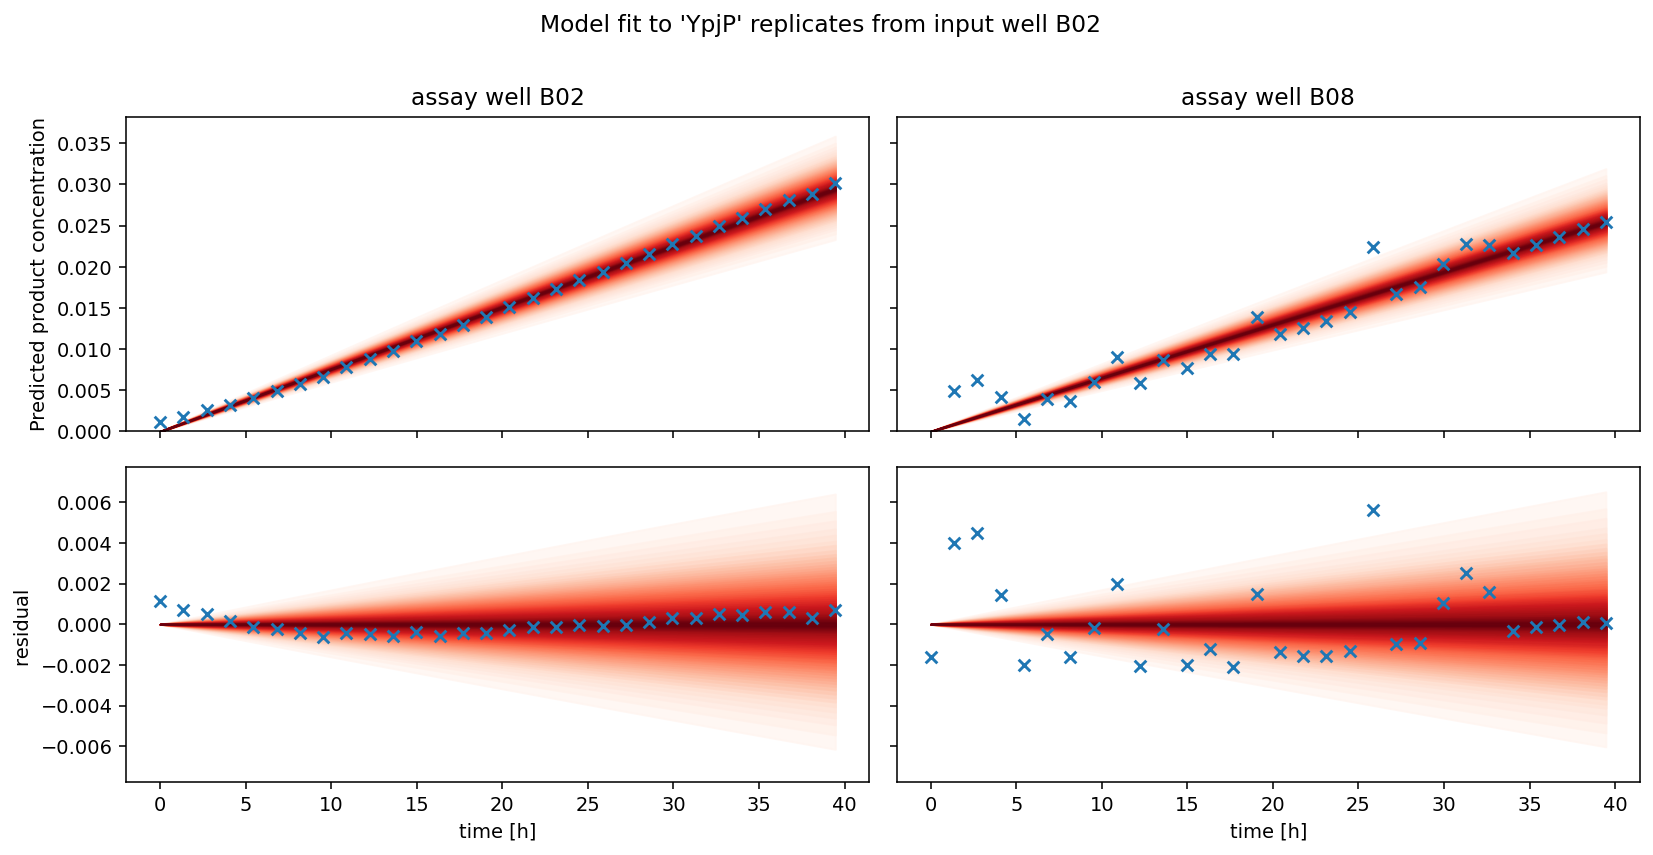

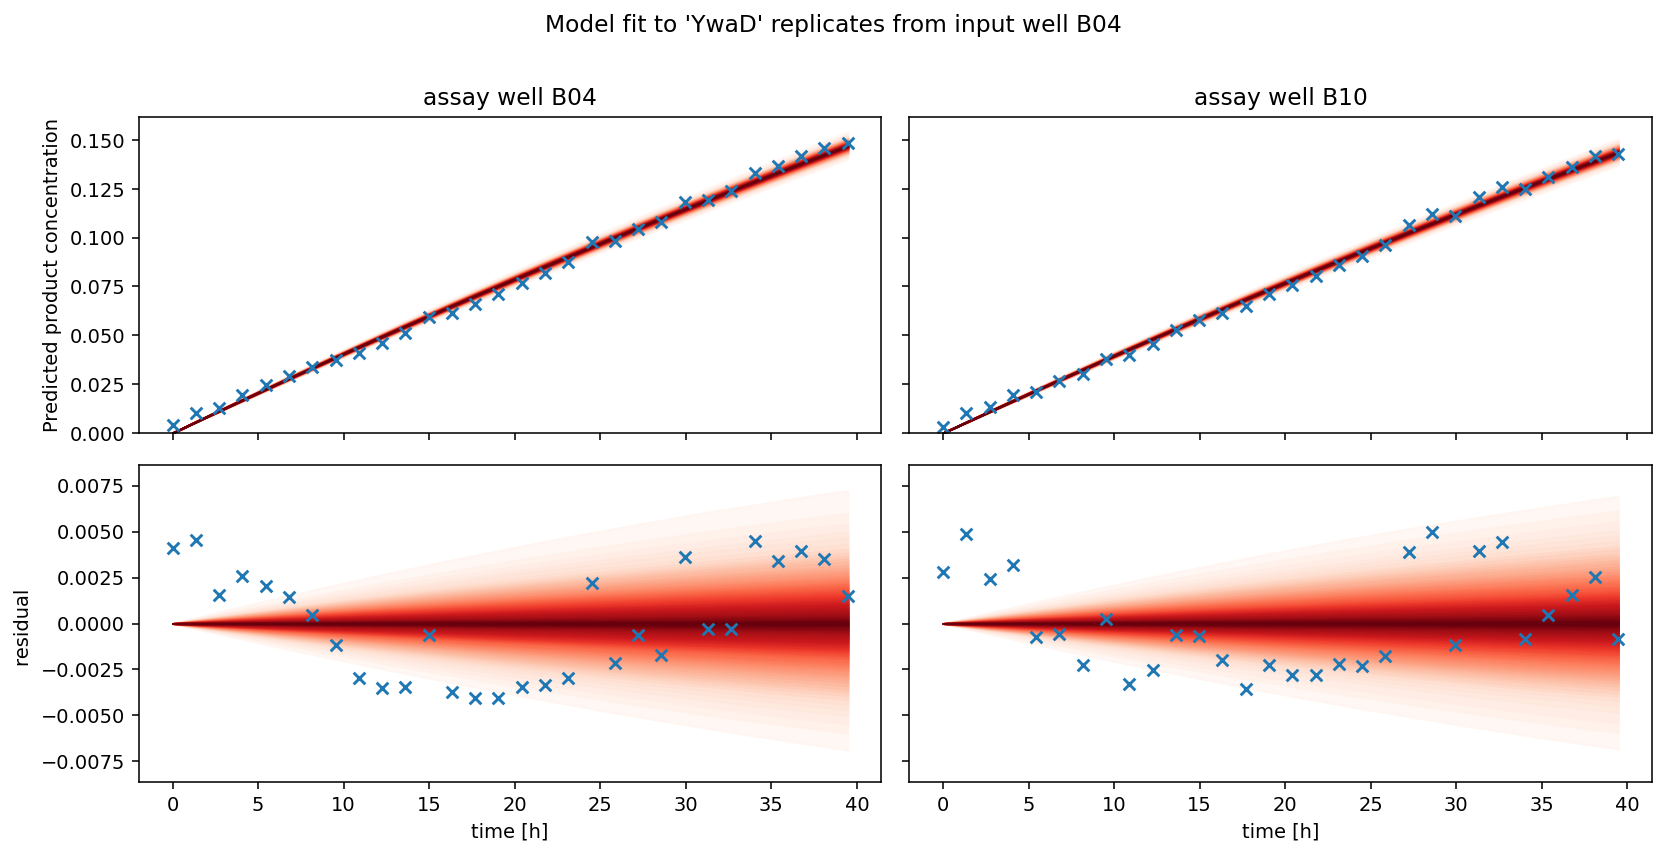

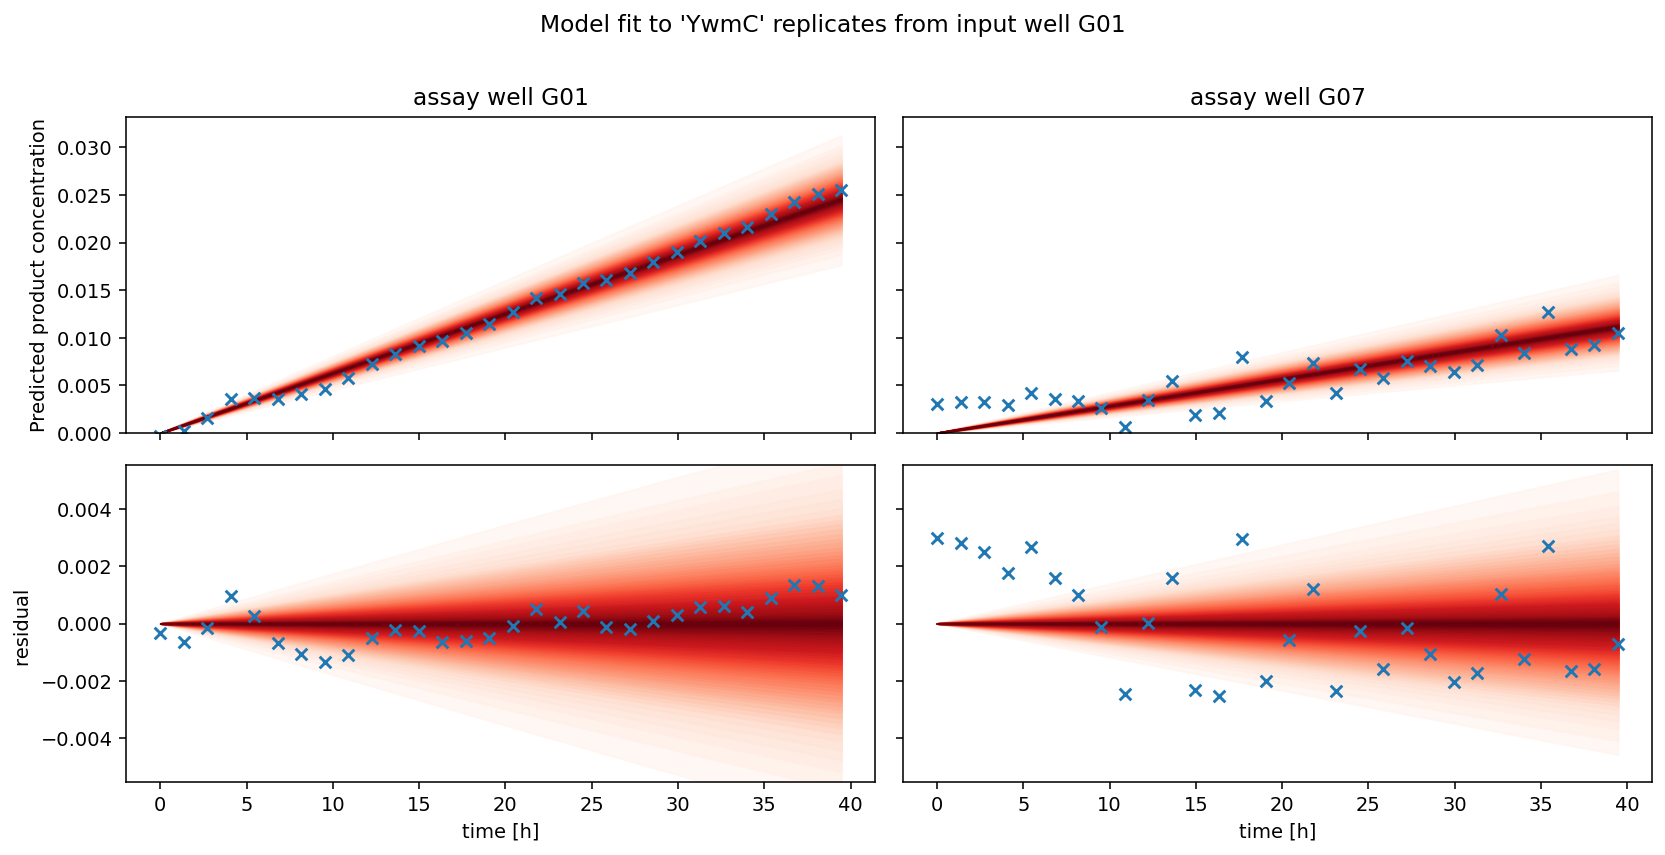

In [33]:
for sample_type in posterior.type.values:
    input_wells = df_inputs[df_inputs.type==sample_type].index.to_list()
    for input_well in input_wells:
        assay_wells = cutisplit.replicate_wells_from([input_well])
        k = posterior.k.sel(type=sample_type)
        cf_input = 1

        # figure constraints
        x_min = min(idata.constant_data.cutinase_time.values.flatten())
        x_max = max(idata.constant_data.cutinase_time.values.flatten())
        x_center = (x_min + x_max) / 2

        fig, axs = pyplot.subplots(
            dpi=140,
            figsize=(12, 6),
            nrows=2,
            ncols=2,
            sharey="row",
            sharex="col",
            squeeze=False,
        )

        residual_ptp = 0
        for c, assay_well in enumerate(assay_wells):
            k_input = k * cf_input
            k_assay = posterior.k_assay.sel(assay_well=assay_well)


            # and the actual product concentration
            pymc3.gp.util.plot_gp_dist(
                ax=axs[0, c],
                samples=posterior.product_concentration.sel(
                    assay_well=assay_well
                ).values.T,
                x=idata.constant_data.cutinase_time[0,:].values,
                samples_alpha=0,
            )
            aw = list(posterior.assay_well.values).index(assay_well)
            absorbance_well = idata.constant_data.cutinase_absorbance.sel(assay_well=aw)
            slope = cm_nitrophenol.theta_fitted[1]
            intercept = numpy.median(posterior.absorbance_intercept.sel(assay_well=assay_well).values)
            axs[0, c].scatter(
                idata.constant_data.cutinase_time.values[0,:],
                (absorbance_well - intercept) / slope,
                marker="x",
            )

            # residuals for the product concentration
            samples = posterior.product_concentration.sel(assay_well=assay_well)
            median = samples.median("sample").values.T
            data = (absorbance_well - intercept) / slope
            residuals = (data - median).values
            residual_ptp = max(residual_ptp, numpy.ptp(residuals))

            pymc3.gp.util.plot_gp_dist(
                ax=axs[1, c],
                samples=(samples.values.T - median),
                x=idata.constant_data.cutinase_time.values[0,:],
                samples_alpha=0,
            )
            axs[1, c].scatter(
                idata.constant_data.cutinase_time.values[0,:], residuals, marker="x"
            )

            # formatting
            axs[0, c].set_title(f"assay well {assay_well}")
            axs[1, c].set_xlabel("time [h]")
        axs[0, 0].set_ylim(0)
        axs[0, 0].set_ylabel(
            "Predicted product concentration"
        )
        axs[1, 0].set_ylim(-residual_ptp, residual_ptp)
        axs[1, 0].set_ylabel("residual ")
        fig.suptitle(
            f"Model fit to '{sample_type}' replicates from input well {input_well}", y=1.01
        )
        fig.tight_layout()